<h1 style="margin:0 0 8px 0;">LLM Production Telemetry — Decision-Grade Observability</h1>
<div style="margin:0 0 10px 0; opacity:0.9;">
Operator notebook: convert telemetry into <b>ship-ready policies</b> — SLO/budget burn → hotspots → routing backtest → drift checks → capacity-aware triage.
</div>

<div style="padding:16px 18px; border:1px solid rgba(255,255,255,0.12); border-radius:16px; background:rgba(255,255,255,0.04);">
  <b>Story setup</b><br/>
  You are the on-call operator for an LLM system. Telemetry is noisy, budgets are limited, and failures have real impact.
  This notebook turns multi-table telemetry into <b>versionable policies</b> you can review, ship, and monitor.
  <br/><br/>

  <b>The decisions you’ll make</b><br/>
  1) Are we burning reliability/SLA budgets — and where?<br/>
  2) What routing + triage policy minimizes cost while staying inside constraints?
  <br/><br/>

  <b>What you will produce</b><br/>
  • <code>routing_policy_use_case.csv</code> — routing policy per use case (cost-aware + SLO-aware)<br/>
  • <code>drift_report.csv</code> — changes across time windows (PSI / TV distance) to flag policy decay<br/>
  • <code>triage_threshold_policy.json</code> — a review threshold based on capacity, risk, and unit costs<br/>
  • <code>triage_actions_preview.csv</code> — a ranked preview of the review queue in the evaluation window<br/>
  • <code>decision_artifact.json</code> — a strict JSON summary intended for automation
  <br/><br/>

  <b>How to run</b><br/>
  1) Set the <code>Operator knobs</code> (SLO, budgets, unit costs, review capacity).<br/>
  2) Run cells top→bottom. If an integrity gate fails, stop and fix inputs before using downstream results.<br/>
  3) Treat outputs as <i>policies</i>: review, version, and monitor them over time.
  <br/><br/>

  <b>Key assumptions</b><br/>
  • Failure is defined by <code>is_failure == 1</code> (or derived from <code>failure_type != "none"</code>).<br/>
  • “Review” is an operator queue action with a per-review cost; false negatives represent business risk.
</div>


In [13]:
from __future__ import annotations

import json
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython import get_ipython
from IPython.display import display
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

try:
    from sklearn.frozen import FrozenEstimator
except Exception:
    FrozenEstimator = None
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import average_precision_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import PredefinedSplit

ip = get_ipython()
if ip is not None:
    try:
        ip.run_line_magic("matplotlib", "inline")
        ip.run_line_magic("config", "InlineBackend.figure_format='retina'")
    except Exception:
        pass

pd.set_option("display.max_columns", 300)
pd.set_option("display.width", 180)
pd.set_option("compute.use_numexpr", False)

RANDOM_SEED = int(os.getenv("RANDOM_SEED", "42"))
np.random.seed(RANDOM_SEED)

SLA_MS = int(os.getenv("SLA_MS", "2200"))

FAIL_BUDGET = float(os.getenv("FAIL_BUDGET", "0.02"))
SLA_BUDGET = float(os.getenv("SLA_BUDGET", "0.05"))

TIME_SPLIT_FRAC = float(os.getenv("TIME_SPLIT_FRAC", "0.80"))

ROUTING_FAIL_BUDGET_MULT = float(os.getenv("ROUTING_FAIL_BUDGET_MULT", "6.0"))
ROUTING_MAX_FAIL_RATE = float(min(0.20, max(FAIL_BUDGET * ROUTING_FAIL_BUDGET_MULT, FAIL_BUDGET)))

HOTSPOT_FAIL_RATE = float(max(FAIL_BUDGET * 3.0, 0.05))

MIN_REQUESTS_POLICY = int(os.getenv("MIN_REQUESTS_POLICY", "60"))
MIN_REQUESTS_SLICE = int(os.getenv("MIN_REQUESTS_SLICE", "60"))

MAX_LATENCY_MISSING_RATE = float(os.getenv("MAX_LATENCY_MISSING_RATE", "0.05"))
MAX_COST_MISSING_RATE = float(os.getenv("MAX_COST_MISSING_RATE", "0.05"))

REVIEW_COST = float(os.getenv("REVIEW_COST", "2.0"))
TRIAGE_FN_COST_USD = float(os.getenv("TRIAGE_FN_COST_USD", "40.0"))
FAILURE_EVENT_COST_USD = float(os.getenv("FAILURE_EVENT_COST_USD", "40.0"))

SLA_BREACH_PENALTY_USD = float(os.getenv("SLA_BREACH_PENALTY_USD", "5.0"))

CAPACITY_PER_DAY = int(os.getenv("CAPACITY_PER_DAY", "200"))
CAPACITY_P90_GUARD = int(os.getenv("CAPACITY_P90_GUARD", "250"))

DAILY_COST_BUDGET_USD = float(os.getenv("DAILY_COST_BUDGET_USD", "60.0"))

OUT_DIR = Path(os.getenv("OUT_DIR", "artifacts"))
OUT_DIR.mkdir(exist_ok=True)

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.figsize": (11, 4.5), "figure.dpi": 120})


TRUE_SET = {"true", "1", "yes", "y", "t"}
FALSE_SET = {"false", "0", "no", "n", "f", ""}


def coerce_bool_series(s: pd.Series, default: bool = False) -> pd.Series:
    """
    Robust boolean coercion for telemetry flags.

    Accepts: bools, 0/1, strings like "true"/"false", "yes"/"no".
    Unknown values fall back to `default`.
    """
    if s is None:
        return pd.Series(default, index=None, dtype="bool")

    if pd.api.types.is_bool_dtype(s):
        return s.fillna(default).astype(bool)

    if pd.api.types.is_numeric_dtype(s):
        v = pd.to_numeric(s, errors="coerce").fillna(0)
        return v.ne(0)

    ss = s.astype("string").str.strip().str.lower()
    is_true = ss.isin(TRUE_SET)
    is_false = ss.isin(FALSE_SET) | ss.isna()
    out = np.where(is_true, True, np.where(is_false, False, default))
    return pd.Series(out, index=s.index, dtype="bool")


def q(x: pd.Series, p: float) -> float:
    v = pd.to_numeric(x, errors="coerce").dropna().astype(float).values
    return float(np.percentile(v, p)) if len(v) else float("nan")


def ensure_col(df: pd.DataFrame, col: str, default):
    if col not in df.columns:
        df[col] = default


def require_cols(df: pd.DataFrame, cols: list[str], name: str):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise KeyError(f"{name} missing columns: {miss}")


def safe_mean(s) -> float:
    return float(pd.to_numeric(s, errors="coerce").mean())


def safe_sum(s) -> float:
    return float(pd.to_numeric(s, errors="coerce").sum())


def breach_rate_non_null(latency_ms: pd.Series, sla_ms: float) -> float:
    lat = pd.to_numeric(latency_ms, errors="coerce")
    nn = lat.notna()
    if int(nn.sum()) == 0:
        return float("nan")
    return float((lat[nn] > sla_ms).mean())


def show_table(df: pd.DataFrame, title: str | None = None, max_rows: int = 30):
    if title:
        print(title)
    display(df.head(max_rows))


def line_chart(
    df: pd.DataFrame,
    x: str,
    ys: list[str],
    title: str,
    hlines: list[tuple[float, str]] | None = None,
):
    ax = df.plot(x=x, y=ys, kind="line")
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.grid(True, alpha=0.3)
    if hlines:
        for y, ls in hlines:
            ax.axhline(y=y, linestyle=ls)
    plt.tight_layout()
    plt.show()


def _read_csv_safe(p: Path) -> pd.DataFrame:
    return pd.read_csv(p) if p.exists() else pd.DataFrame()


def _read_json_safe(p: Path) -> dict:
    if not p.exists():
        return {}
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return {}

<h2 style="margin:24px 0 10px 0;">Load data</h2>
<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
<b>Why it matters</b><br/>
If the notebook can’t reliably find your tables, everything downstream becomes fragile.
This loader searches common locations (local, <code>/mnt/data</code>, Kaggle input) and fails fast if required files are missing.
</div>


In [14]:
REQ = [
    "llm_system_interactions.csv",
    "llm_system_sessions_summary.csv",
    "llm_system_users_summary.csv",
]

OPT = [
    "llm_system_prompts_lookup.csv",
    "llm_system_instruction_tuning_samples.csv",
]


def _find_file(root: Path, filename: str) -> Path | None:
    root = root.expanduser().resolve()
    p = root / filename
    if p.exists():
        return p

    if str(root) == "/kaggle/input" and root.exists():
        try:
            for d in root.iterdir():
                if d.is_dir():
                    p2 = d / filename
                    if p2.exists():
                        return p2
        except Exception:
            pass

    try:
        for hit in root.rglob(filename):
            if hit.exists():
                return hit
    except Exception:
        return None
    return None


def resolve_paths() -> dict[str, Path]:
    candidates: list[Path] = []
    env = os.getenv("LLMOPS_DATA_DIR", "").strip()
    if env:
        candidates.append(Path(env))
    candidates += [Path.cwd(), Path.cwd() / "data", Path("/mnt/data")]
    kroot = Path("/kaggle/input")
    if kroot.exists():
        candidates.append(kroot)

    found: dict[str, Path] = {}
    for fn in REQ + OPT:
        for root in candidates:
            p = _find_file(root, fn)
            if p is not None:
                found[fn] = p
                break
    return found


paths = resolve_paths()


def read_csv(name: str) -> pd.DataFrame | None:
    p = paths.get(name)
    if p is None:
        return None
    return pd.read_csv(p)


interactions = read_csv("llm_system_interactions.csv")
sessions = read_csv("llm_system_sessions_summary.csv")
users = read_csv("llm_system_users_summary.csv")
prompts = read_csv("llm_system_prompts_lookup.csv")
sft = read_csv("llm_system_instruction_tuning_samples.csv")

missing = [
    k
    for k, v in {
        "llm_system_interactions.csv": interactions,
        "llm_system_sessions_summary.csv": sessions,
        "llm_system_users_summary.csv": users,
    }.items()
    if v is None
]

if missing:
    raise FileNotFoundError(
        f"Missing required CSV(s): {missing}. Resolved search paths: "
        f"{sorted(set(str(p.parent) for p in paths.values()))}"
    )

print("Loaded:", interactions.shape, sessions.shape, users.shape)

Loaded: (9000, 55) (1595, 37) (438, 21)


<h2 style="margin:24px 0 10px 0;">Normalize types + integrity gates</h2>
<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
<b>Hard gate</b><br/>
We stop if primary keys are not unique, foreign keys don’t match, or token accounting is inconsistent.
If this passes, later plots and policies are worth believing.
</div>


In [15]:
interactions = interactions.copy()
sessions = sessions.copy()
users = users.copy()

interactions["timestamp_utc"] = pd.to_datetime(
    interactions.get("timestamp_utc"), utc=True, errors="coerce"
)
if interactions["timestamp_utc"].notna().sum() == 0 and "date_utc" in interactions.columns:
    d = pd.to_datetime(interactions["date_utc"], utc=True, errors="coerce")
    h = pd.to_numeric(interactions.get("hour_of_day_utc"), errors="coerce").fillna(0).astype(int)
    interactions["timestamp_utc"] = d + pd.to_timedelta(h, unit="h")

for c in ["start_timestamp_utc", "end_timestamp_utc"]:
    if c in sessions.columns:
        sessions[c] = pd.to_datetime(sessions[c], utc=True, errors="coerce")

num_cols = [
    "latency_ms",
    "prompt_tokens",
    "completion_tokens",
    "total_tokens",
    "cost_usd",
    "tool_calls_count",
    "response_quality_score",
    "user_feedback_score",
    "tokens_per_second",
    "temperature",
    "top_p",
    "max_tokens",
    "retry_index",
]
for c in num_cols:
    if c in interactions.columns:
        interactions[c] = pd.to_numeric(interactions[c], errors="coerce")

interactions.replace([np.inf, -np.inf], np.nan, inplace=True)

if "tokens_per_second" not in interactions.columns and {"total_tokens", "latency_ms"}.issubset(
    interactions.columns
):
    denom = pd.to_numeric(interactions["latency_ms"], errors="coerce") / 1000.0
    interactions["tokens_per_second"] = pd.to_numeric(
        interactions["total_tokens"], errors="coerce"
    ) / denom.replace(0, np.nan)

if "prompt_to_completion_ratio" not in interactions.columns and {
    "prompt_tokens",
    "completion_tokens",
}.issubset(interactions.columns):
    pt = pd.to_numeric(interactions["prompt_tokens"], errors="coerce").round().astype("Int64")
    ct = pd.to_numeric(interactions["completion_tokens"], errors="coerce").round().astype("Int64")
    interactions["prompt_to_completion_ratio"] = pt / ct.replace(0, np.nan)

require_cols(interactions, ["interaction_id", "session_id", "user_id"], "interactions")
require_cols(sessions, ["session_id", "user_id"], "sessions")
require_cols(users, ["user_id"], "users")

if not interactions["interaction_id"].is_unique:
    raise ValueError("interactions.interaction_id must be unique")
if not sessions["session_id"].is_unique:
    raise ValueError("sessions.session_id must be unique")
if not users["user_id"].is_unique:
    raise ValueError("users.user_id must be unique")

if not interactions["session_id"].isin(sessions["session_id"]).all():
    raise ValueError("FK failed: interactions.session_id → sessions.session_id")
if not interactions["user_id"].isin(users["user_id"]).all():
    raise ValueError("FK failed: interactions.user_id → users.user_id")

if sft is not None and "interaction_id" in sft.columns:
    if not sft["interaction_id"].is_unique:
        raise ValueError("sft.interaction_id must be unique (1:1)")
    if not sft["interaction_id"].isin(interactions["interaction_id"]).all():
        raise ValueError("FK failed: sft.interaction_id → interactions.interaction_id")

if {"total_tokens", "prompt_tokens", "completion_tokens"}.issubset(interactions.columns):
    tt = pd.to_numeric(interactions["total_tokens"], errors="coerce").round().astype("Int64")
    pt = pd.to_numeric(interactions["prompt_tokens"], errors="coerce").round().astype("Int64")
    ct = pd.to_numeric(interactions["completion_tokens"], errors="coerce").round().astype("Int64")
    mask = tt.notna() & pt.notna() & ct.notna()
    if mask.sum() == 0:
        raise ValueError("Invariant check skipped: token columns exist but have no non-null rows")
    bad = tt[mask] != (pt[mask] + ct[mask])
    if bad.any():
        raise ValueError(
            "Invariant violated: total_tokens != prompt_tokens + completion_tokens (non-null rows)"
        )

FLAG_COLS = [
    "safety_block_flag",
    "hallucination_flag",
    "toxicity_flag",
    "formatting_error_flag",
    "tool_error_flag",
    "latency_timeout_flag",
]
for c in FLAG_COLS:
    ensure_col(interactions, c, False)
    interactions[c] = coerce_bool_series(interactions[c], default=False)

ensure_col(interactions, "is_failure", np.nan)
interactions["is_failure"] = pd.to_numeric(interactions["is_failure"], errors="coerce")
interactions["is_failure_was_missing"] = interactions["is_failure"].isna()

if "failure_type" in interactions.columns:
    ft = interactions["failure_type"].astype("string").fillna("none").str.strip().str.lower()
    derived = (ft != "none").astype("int64")
else:
    derived = pd.Series(0, index=interactions.index, dtype="int64")

na_mask = interactions["is_failure"].isna()
if na_mask.any():
    interactions.loc[na_mask, "is_failure"] = derived.loc[na_mask]

interactions["is_failure"] = (
    pd.to_numeric(interactions["is_failure"], errors="coerce").fillna(0).astype("int64").clip(0, 1)
)

print("Integrity OK")

Integrity OK


<h2 style='margin:22px 0 10px 0;'>Join sessions + users</h2>


In [16]:
i = interactions.copy()
s = sessions.copy()
u = users.copy()

for c in [
    "use_case",
    "account_tier",
    "channel",
    "model_provider",
    "model_name",
    "region",
    "segment",
]:
    ensure_col(i, c, "unknown")

for c in [
    "session_total_cost_usd",
    "session_total_tokens",
    "session_total_requests",
    "session_total_failures",
]:
    ensure_col(s, c, np.nan)

for c in ["user_total_cost_usd", "user_total_requests", "user_total_failures"]:
    ensure_col(u, c, np.nan)

i["session_id"] = i["session_id"].astype(str)
i["user_id"] = i["user_id"].astype(str)
s["session_id"] = s["session_id"].astype(str)
s["user_id"] = s["user_id"].astype(str)
u["user_id"] = u["user_id"].astype(str)

inter = i.merge(
    s.drop(columns=[c for c in ["user_id"] if c in s.columns], errors="ignore"),
    on="session_id",
    how="left",
    validate="many_to_one",
    suffixes=("", "_session"),
)

inter = inter.merge(
    u,
    on="user_id",
    how="left",
    validate="many_to_one",
    suffixes=("", "_user"),
)

df_time = inter.dropna(subset=["timestamp_utc"]).sort_values("timestamp_utc").reset_index(drop=True)

train_hist = df_time.copy()
val_window = df_time.iloc[0:0].copy()
test_future = df_time.iloc[0:0].copy()
cut_ts = None

use_split = ("split" in df_time.columns) and df_time["split"].isin(["train", "val", "test"]).any()
if use_split:
    train_hist = df_time[df_time["split"].eq("train")].copy()
    val_window = df_time[df_time["split"].eq("val")].copy()
    test_future = df_time[df_time["split"].eq("test")].copy()
else:
    if len(df_time) == 0:
        train_hist = df_time.copy()
        val_window = df_time.copy()
        test_future = df_time.copy()
    else:
        cut_idx = int(TIME_SPLIT_FRAC * len(df_time))
        cut_ts = df_time.loc[cut_idx, "timestamp_utc"]

        session_start = df_time.groupby("session_id")["timestamp_utc"].min()
        hist_sessions = set(session_start[session_start <= cut_ts].index.astype(str))
        train_hist = df_time[df_time["session_id"].astype(str).isin(hist_sessions)].copy()
        test_future = df_time[~df_time["session_id"].astype(str).isin(hist_sessions)].copy()
        val_window = df_time.iloc[0:0].copy()

overlap = set(train_hist["session_id"].astype(str)) & set(test_future["session_id"].astype(str))
if overlap:
    raise ValueError(
        f"Stop-ship: history/evaluation share {len(overlap)} session_id(s); example={sorted(list(overlap))[:3]}"
    )

print(
    "Windows:",
    f"train={train_hist.shape}",
    f"val={val_window.shape}",
    f"test={test_future.shape}",
    f"windowing={'dataset_split' if use_split else 'session_safe_time_split'}",
)

Windows: train=(6952, 118) val=(1041, 118) test=(1007, 118) windowing=dataset_split


<h2 style="margin:24px 0 10px 0;">1) Health snapshot</h2>
<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
<b>First question</b><br/>
Are we healthy right now? We summarize failure rate, SLA breach rate, p95 latency, cost, and tool/safety usage.
This tells you if you’re in “monitor” mode or “incident” mode.
</div>


System snapshot


,Metric,Value
0,Interactions,"9,000"
1,Failure rate,28.41%
2,SLA breach rate (non-null latency),6.24%
3,latency_ms missing rate,0.00%
4,cost_usd missing rate,0.00%
5,is_failure missing rate (raw),0.00%
6,p95 latency (ms),2309
7,Total cost (estimated),"$1,748.19"
8,Avg cost/request,$0.1942
9,Tool usage share,28.56%


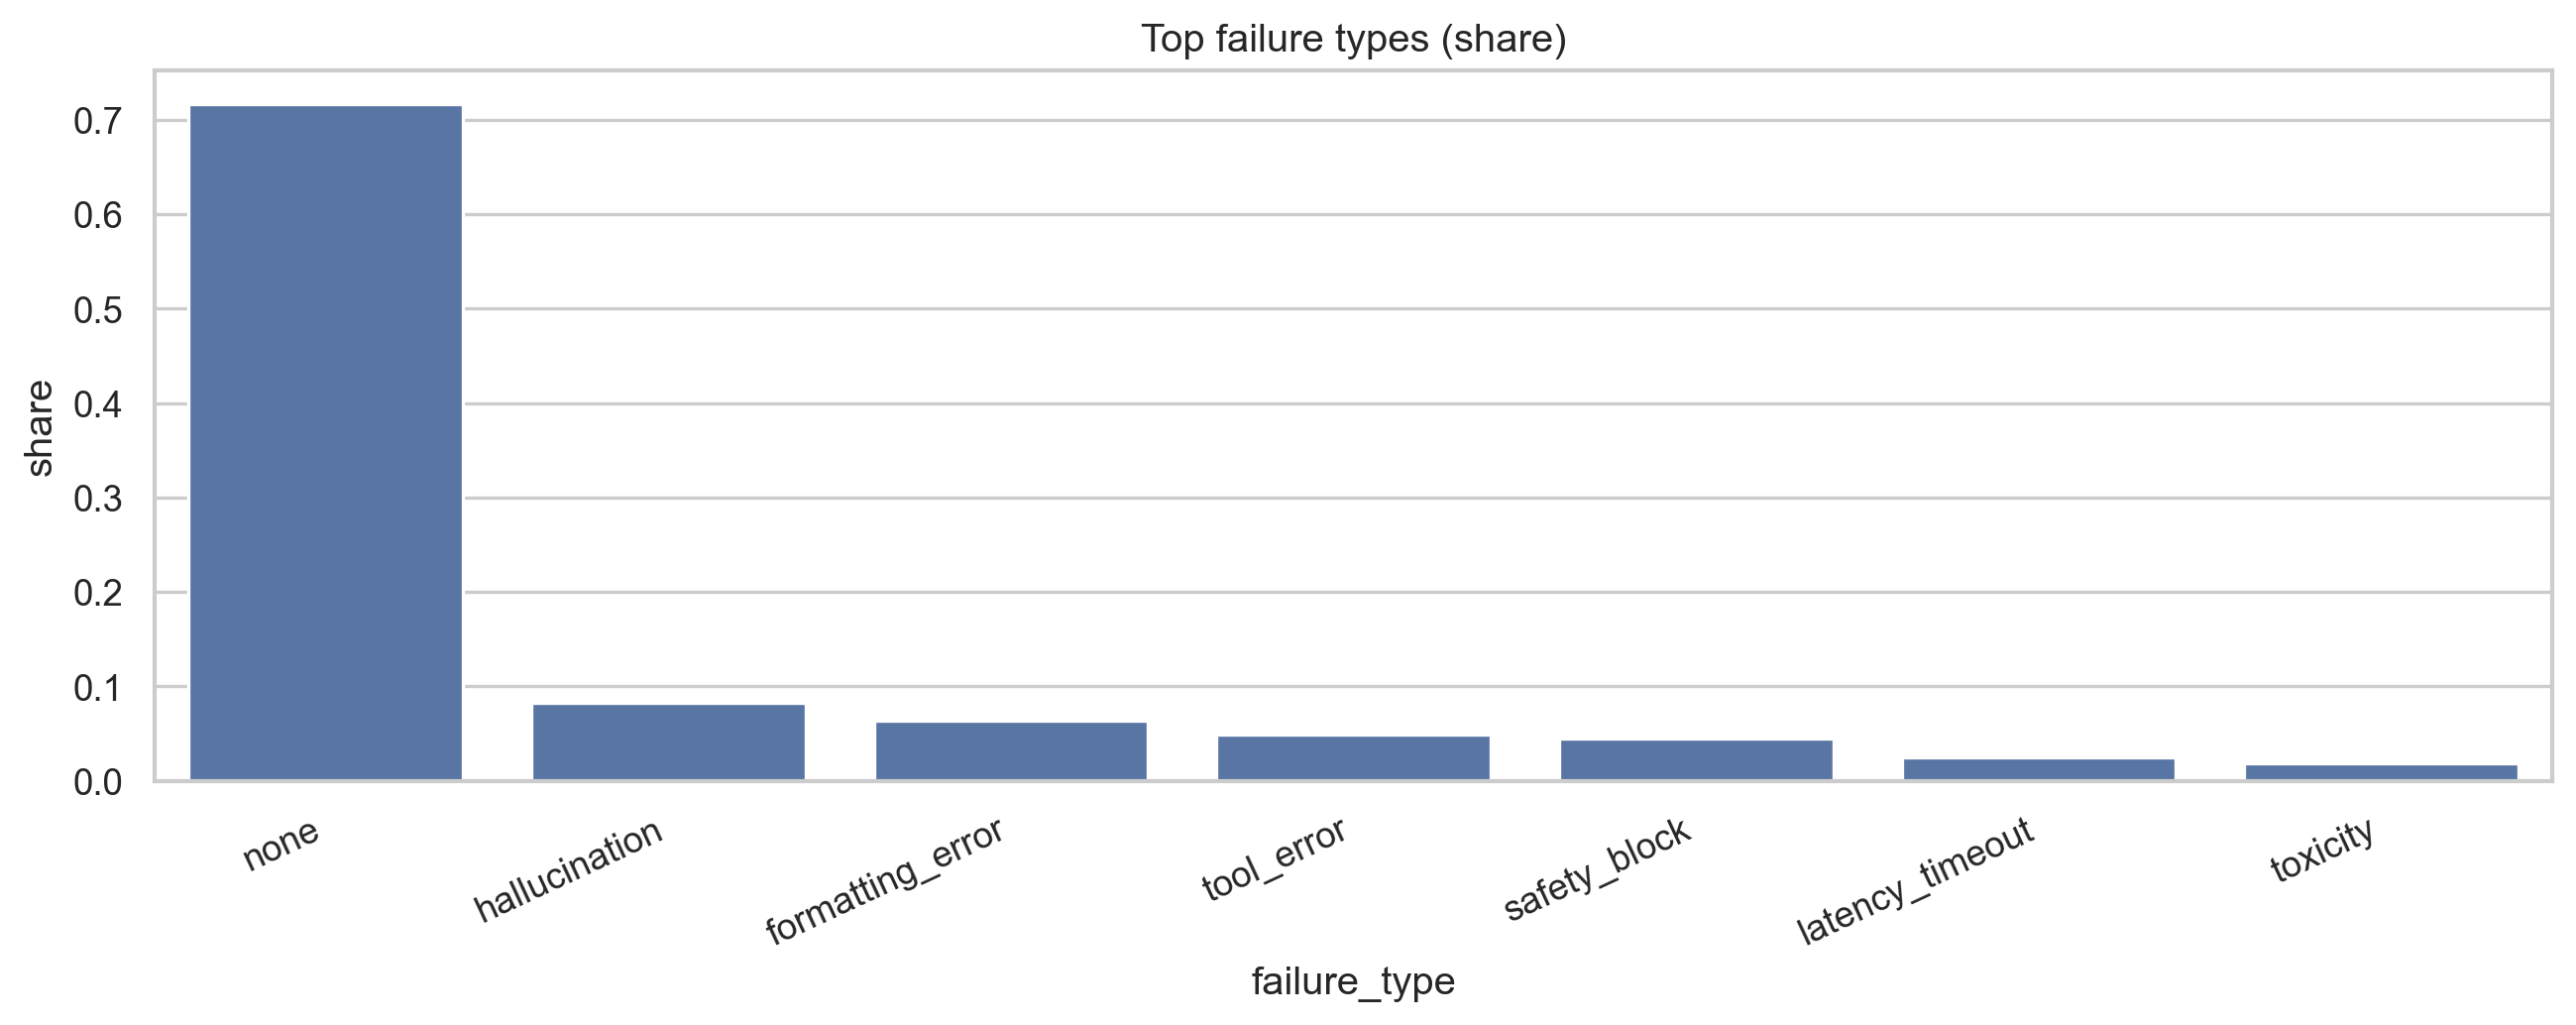

In [17]:
ensure_col(inter, "failure_type", "unknown")
ensure_col(inter, "latency_ms", np.nan)
ensure_col(inter, "cost_usd", np.nan)
ensure_col(inter, "tool_calls_count", 0)

flags = [
    "safety_block_flag",
    "hallucination_flag",
    "toxicity_flag",
    "formatting_error_flag",
    "tool_error_flag",
    "latency_timeout_flag",
]
for c in flags:
    ensure_col(inter, c, False)
    inter[c] = coerce_bool_series(inter[c], default=False)

lat = pd.to_numeric(inter["latency_ms"], errors="coerce")
tc = pd.to_numeric(inter["tool_calls_count"], errors="coerce").fillna(0).astype(int)

lat_non_null = lat.notna()
lat_missing_rate = float((~lat_non_null).mean())

cost_num = pd.to_numeric(inter["cost_usd"], errors="coerce")
cost_missing_rate = float(cost_num.isna().mean())

is_fail_missing = pd.Series(False, index=inter.index)
if "is_failure_was_missing" in inter.columns:
    is_fail_missing = coerce_bool_series(inter["is_failure_was_missing"], default=False)
failure_missing_rate = float(is_fail_missing.mean())

sla_breach_rate_nn = (
    float((lat[lat_non_null] > SLA_MS).mean()) if int(lat_non_null.sum()) else float("nan")
)

if np.isfinite(lat_missing_rate) and (lat_missing_rate > MAX_LATENCY_MISSING_RATE):
    raise ValueError(
        f"Stop-ship: latency_ms missing rate {lat_missing_rate:.2%} exceeds "
        f"MAX_LATENCY_MISSING_RATE={MAX_LATENCY_MISSING_RATE:.2%}. "
        "Fill/estimate latency before trusting SLO burn, routing, or triage outputs."
    )
if np.isfinite(cost_missing_rate) and (cost_missing_rate > MAX_COST_MISSING_RATE):
    raise ValueError(
        f"Stop-ship: cost_usd missing rate {cost_missing_rate:.2%} exceeds "
        f"MAX_COST_MISSING_RATE={MAX_COST_MISSING_RATE:.2%}. "
        "Fill/estimate costs (or provide a pricing table) before trusting cost-aware policies."
    )

kpis = pd.DataFrame(
    [
        ("Interactions", f"{len(inter):,}"),
        ("Failure rate", f"{safe_mean(inter['is_failure']) * 100:.2f}%"),
        ("SLA breach rate (non-null latency)", f"{sla_breach_rate_nn * 100:.2f}%"),
        ("latency_ms missing rate", f"{lat_missing_rate * 100:.2f}%"),
        ("cost_usd missing rate", f"{cost_missing_rate * 100:.2f}%"),
        ("is_failure missing rate (raw)", f"{failure_missing_rate * 100:.2f}%"),
        ("p95 latency (ms)", f"{q(lat, 95):.0f}"),
        ("Total cost (estimated)", f"${safe_sum(inter['cost_usd']):,.2f}"),
        ("Avg cost/request", f"${safe_mean(inter['cost_usd']):.4f}"),
        ("Tool usage share", f"{float((tc > 0).mean()) * 100:.2f}%"),
        (
            "Safety blocks share",
            f"{float(inter['safety_block_flag'].astype(bool).mean()) * 100:.2f}%",
        ),
    ],
    columns=["Metric", "Value"],
)
show_table(kpis, title="System snapshot", max_rows=50)

mix = (
    inter["failure_type"]
    .astype("string")
    .fillna("unknown")
    .str.strip()
    .str.lower()
    .value_counts(normalize=True)
    .head(12)
    .reset_index()
)
mix.columns = ["failure_type", "share"]
plt.figure()
ax = sns.barplot(data=mix, x="failure_type", y="share")
ax.set_title("Top failure types (share)")
ax.set_xlabel("failure_type")
ax.set_ylabel("share")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()

<h2 style='margin:22px 0 10px 0;'>2) SLO / error budget burn</h2>


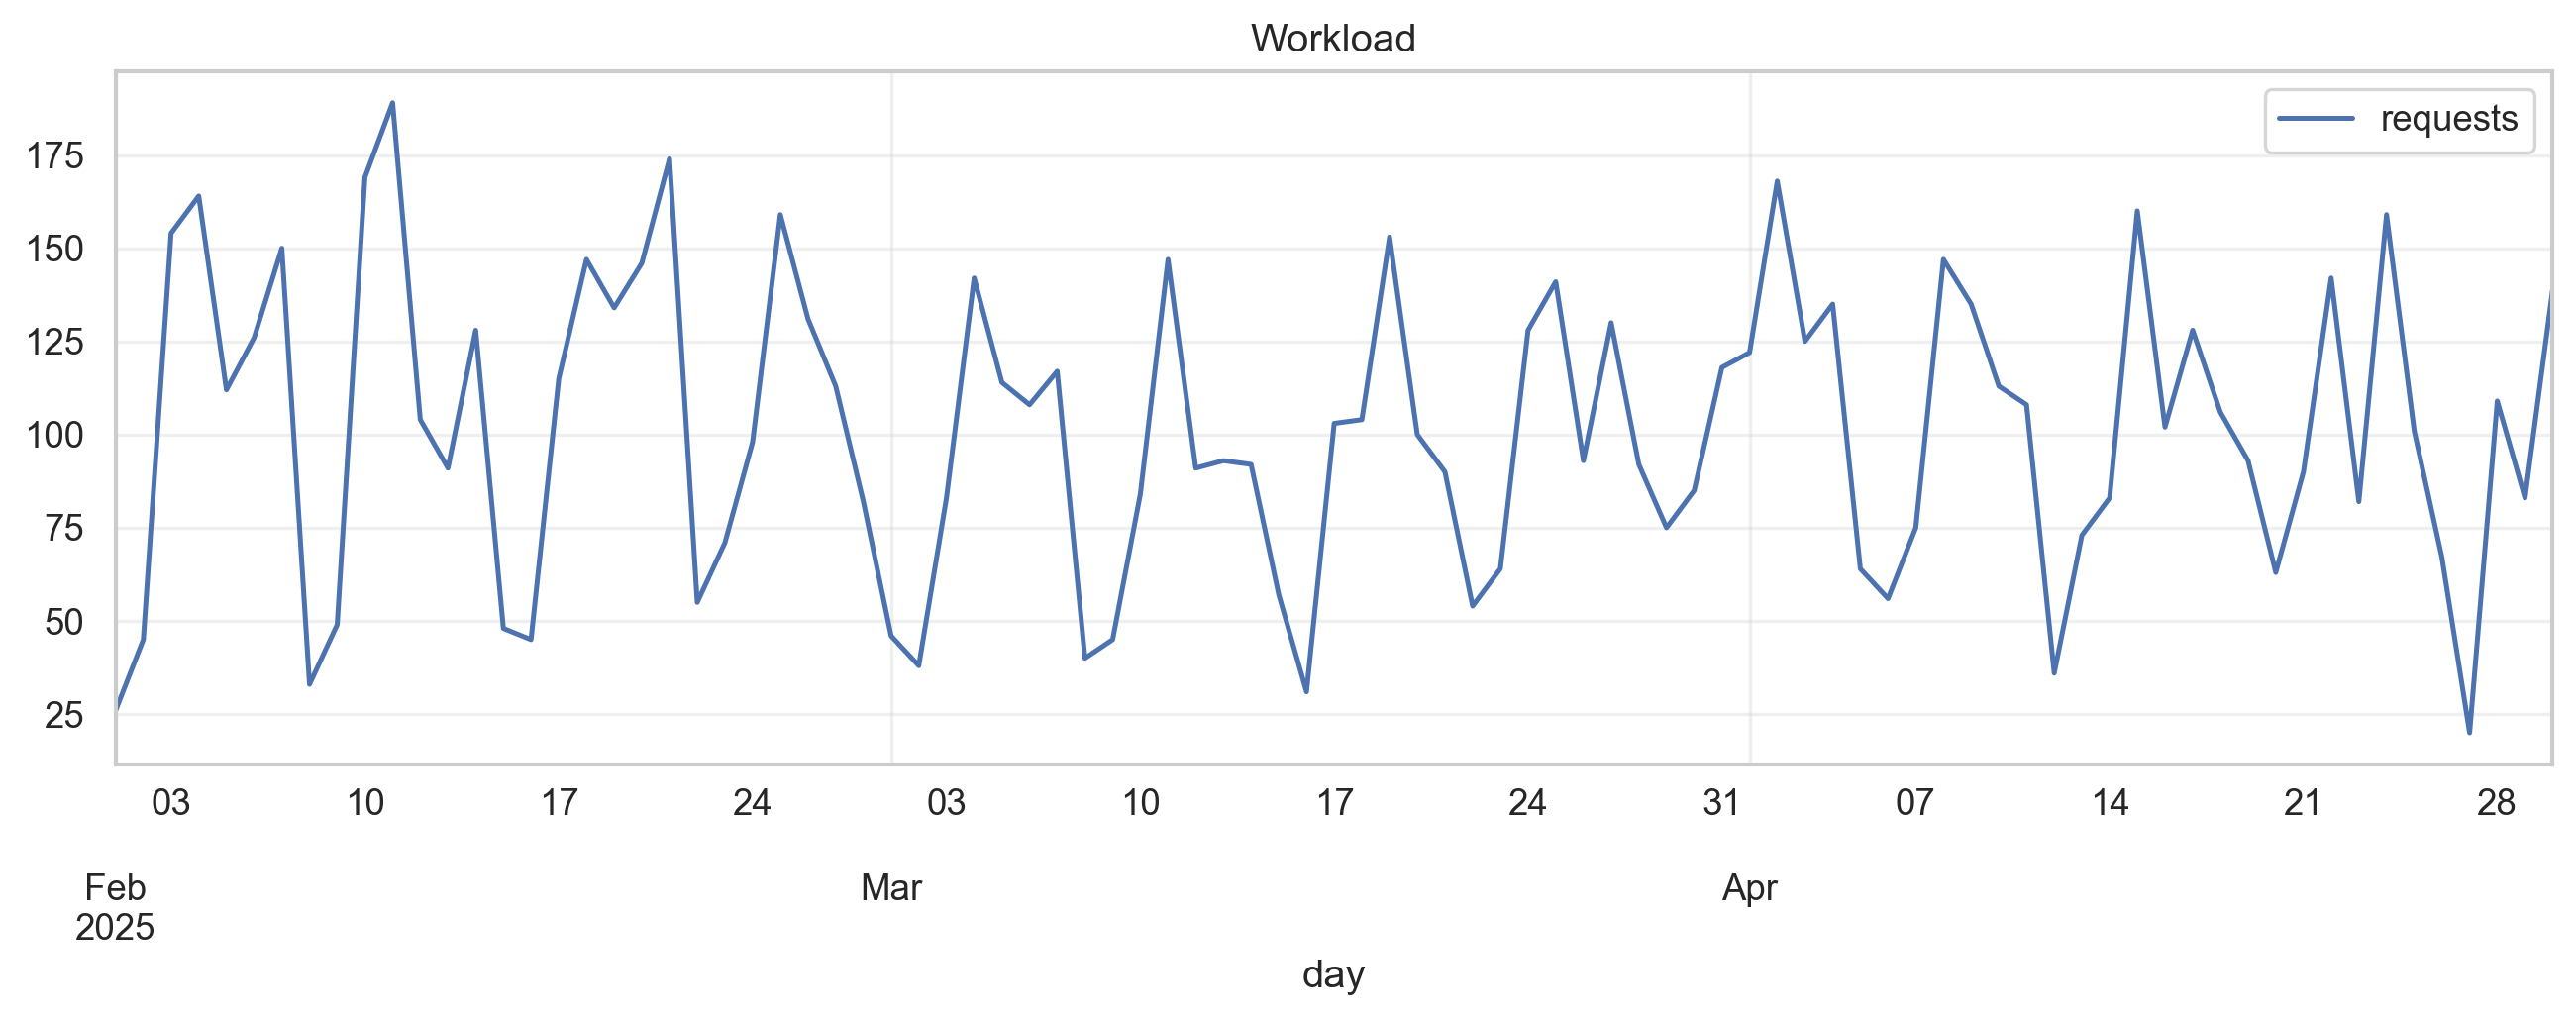

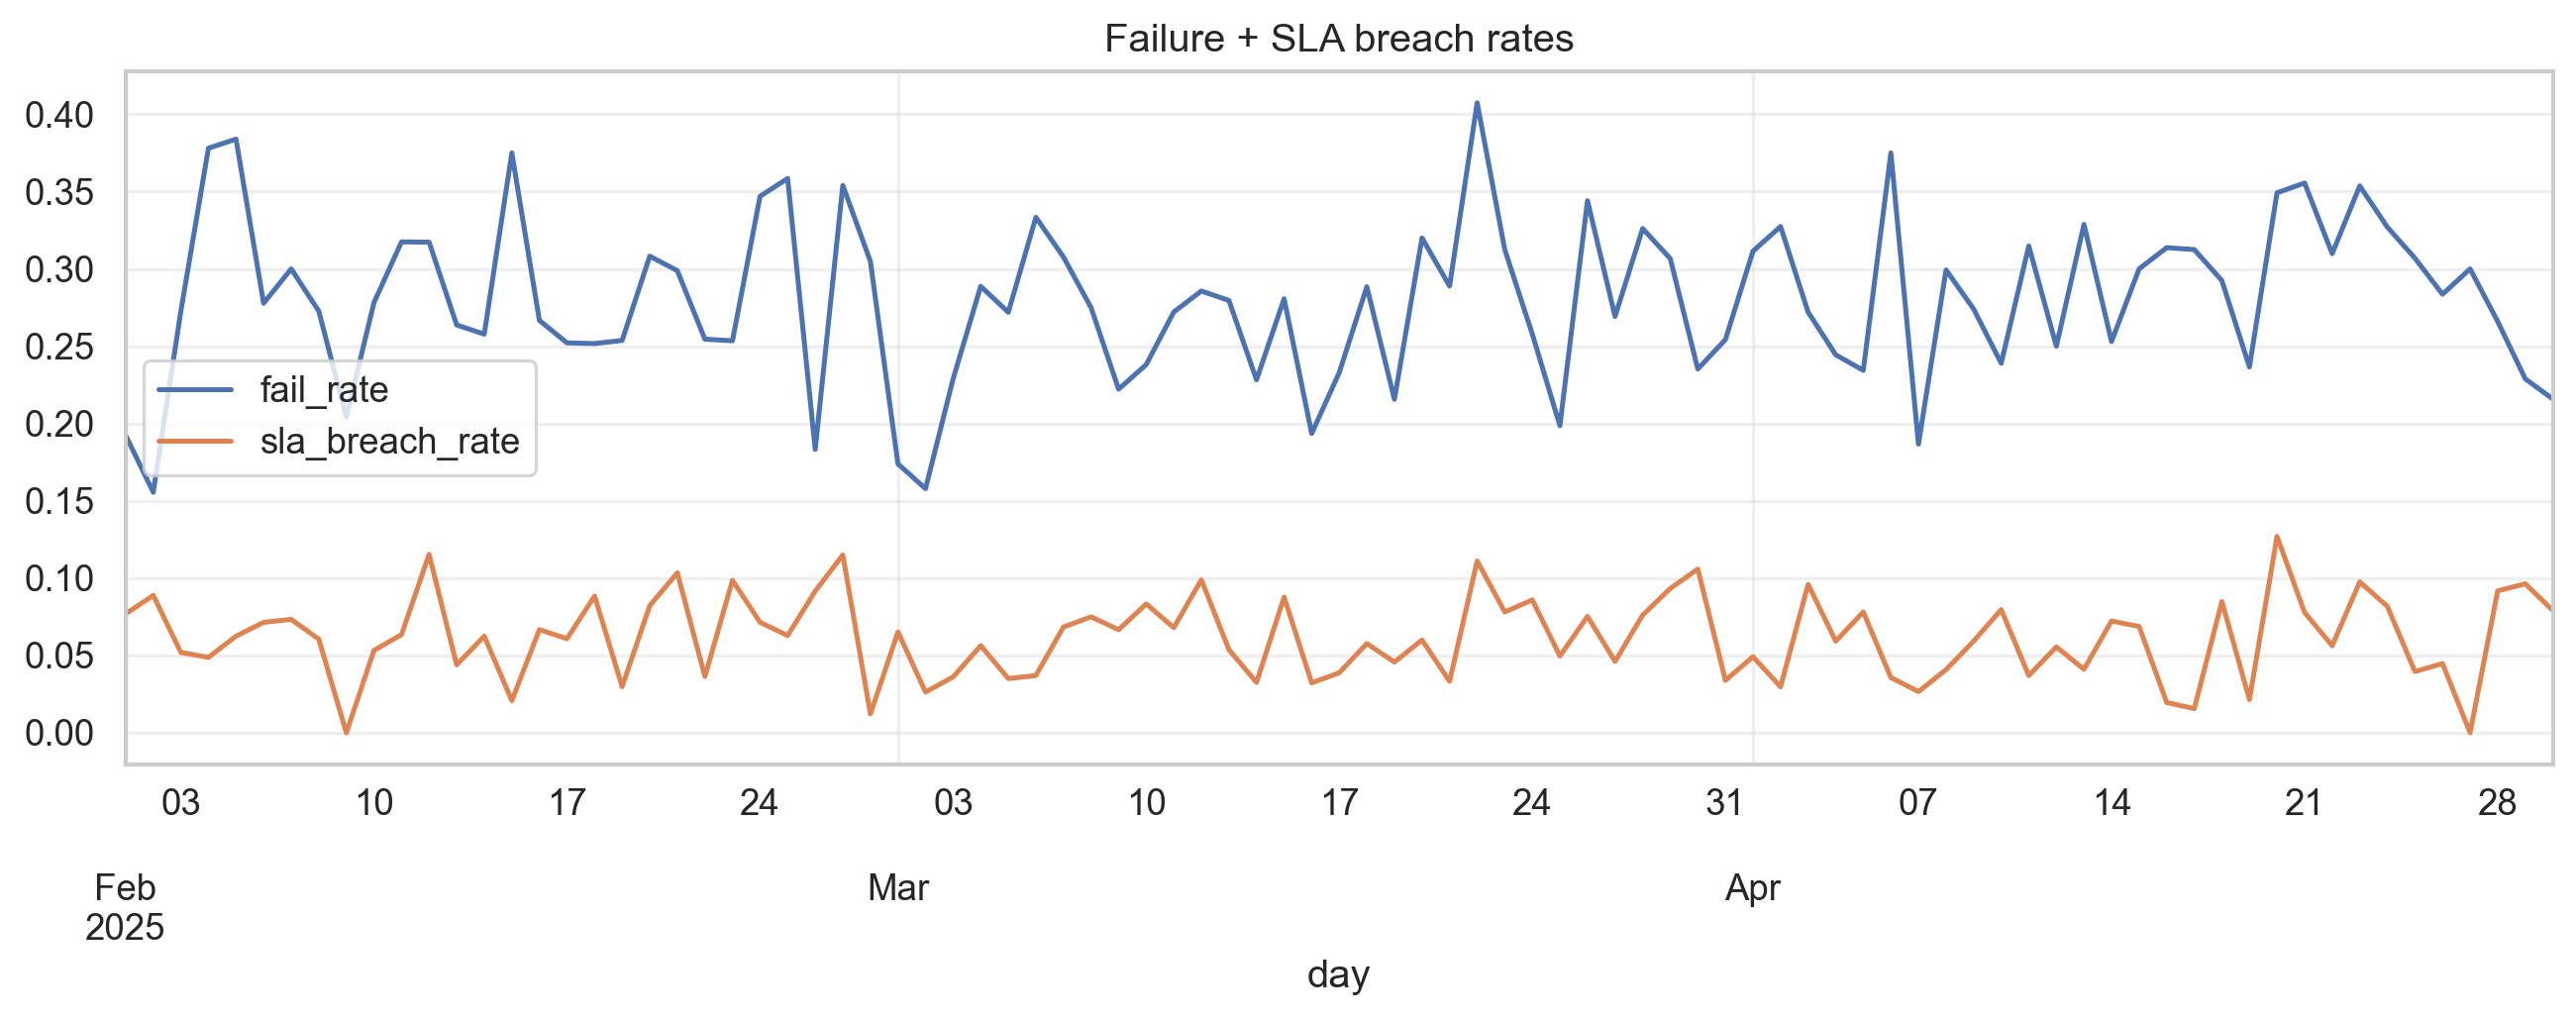

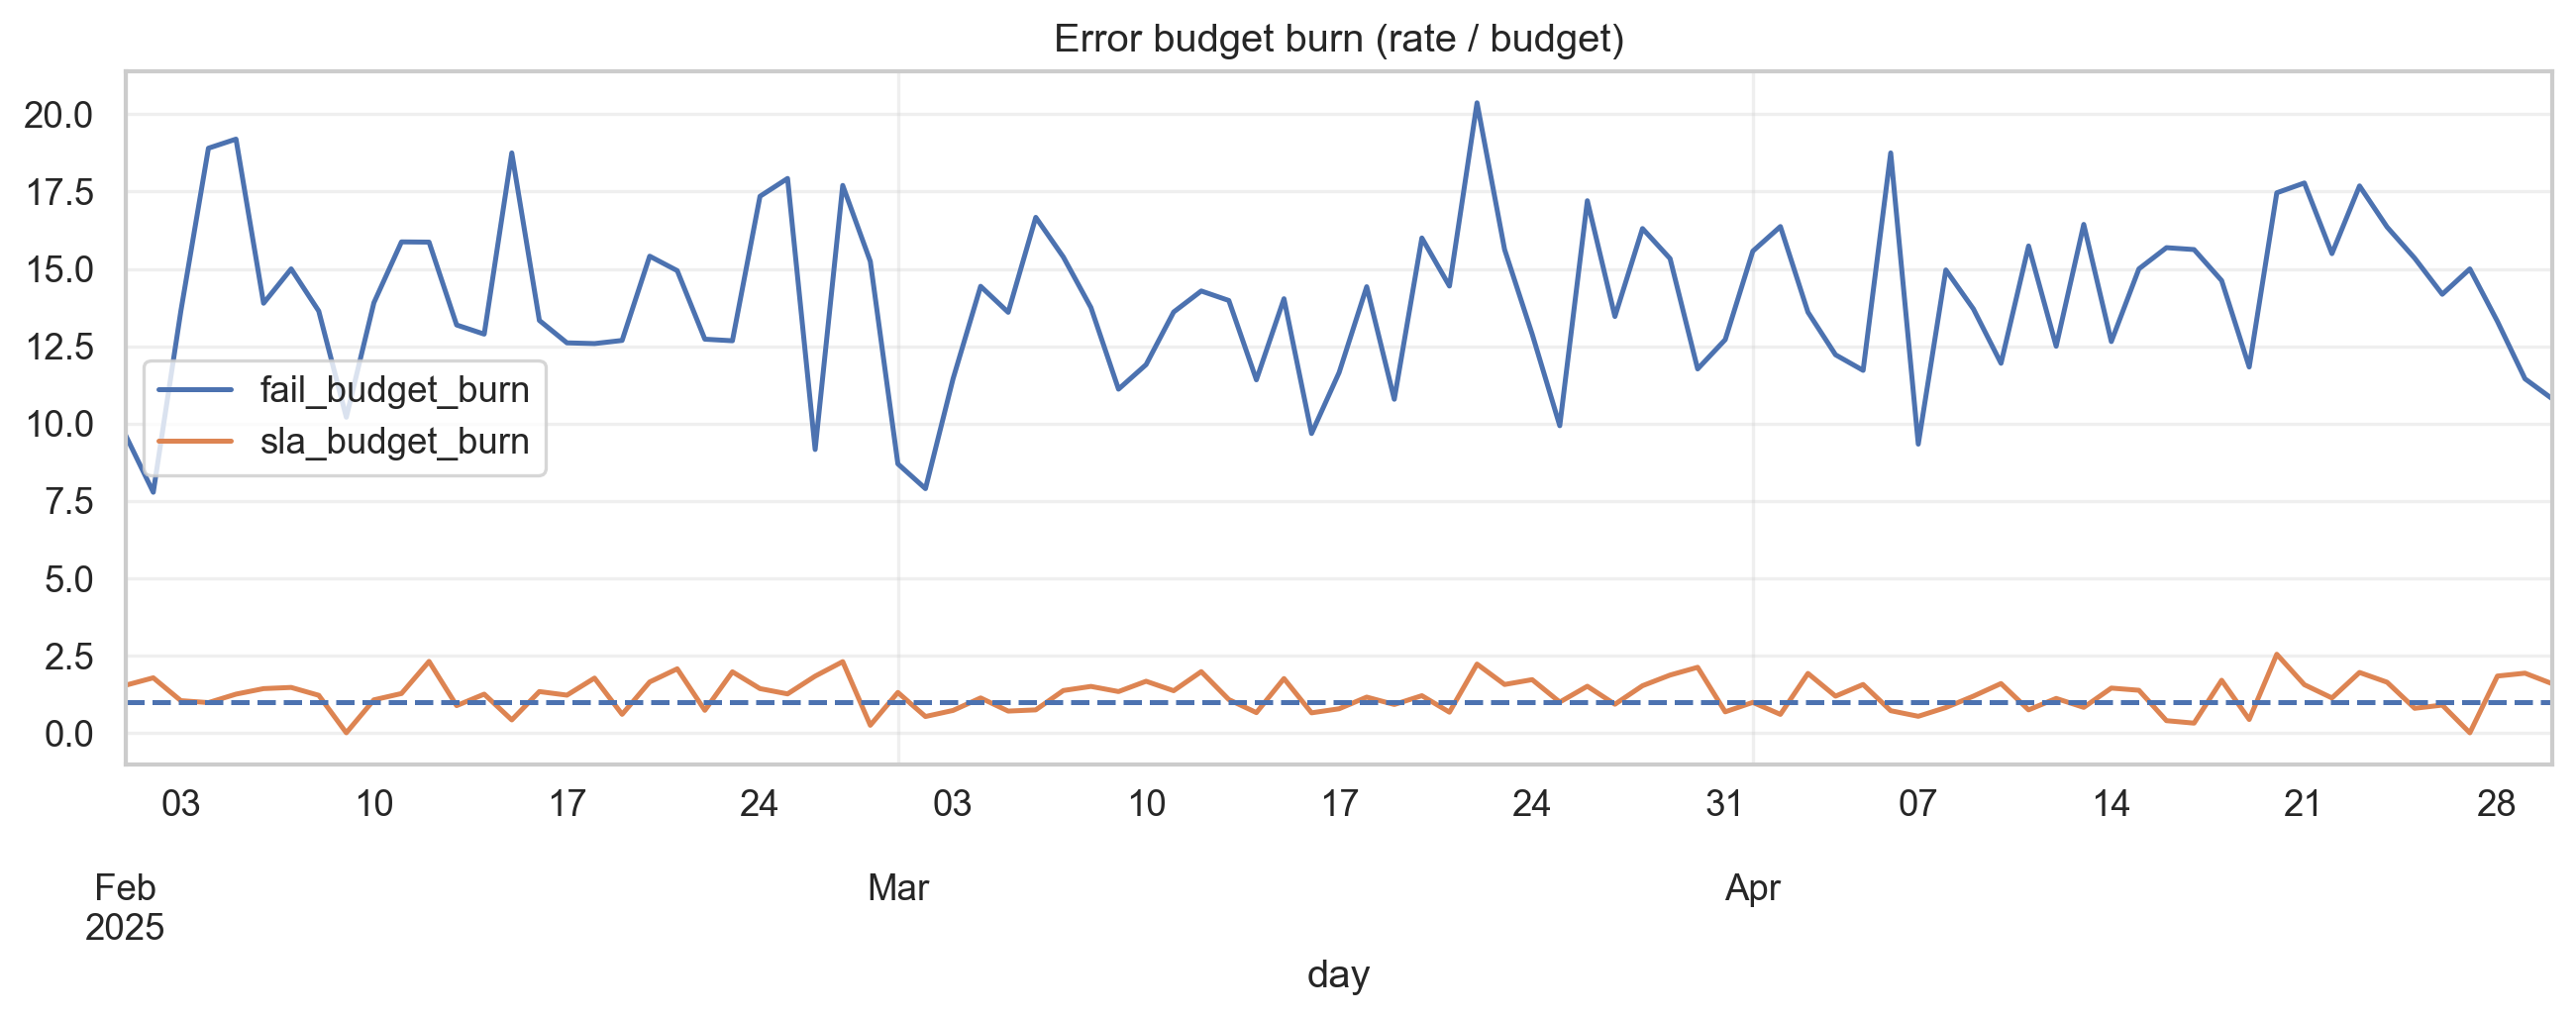

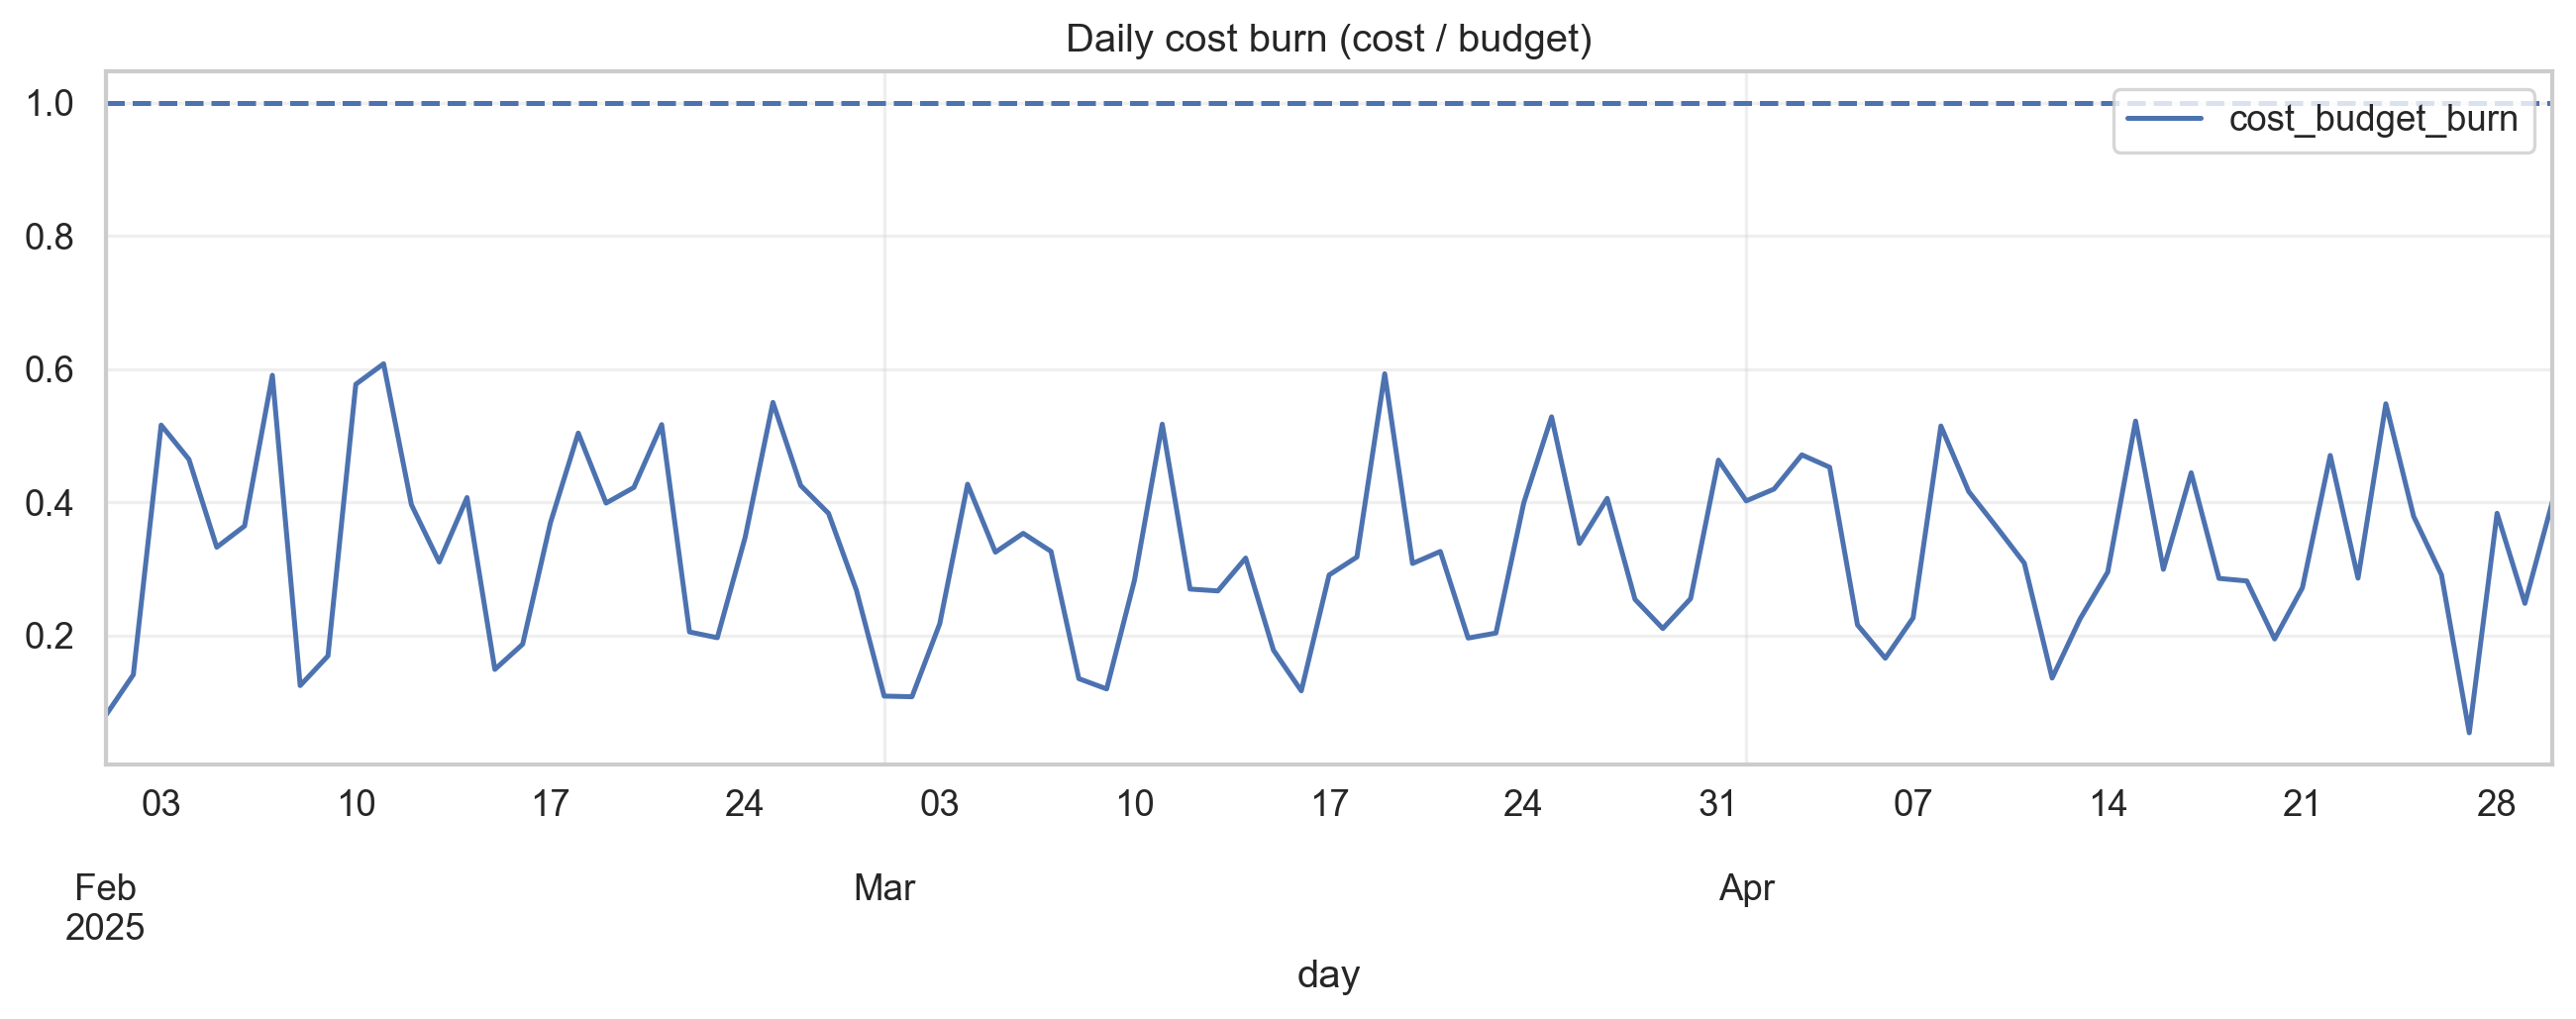

Daily summary (latest)


,day,requests,fail_rate,sla_breach_rate,cost,p95_latency,fail_budget_burn,sla_budget_burn,cost_budget_burn
88,2025-04-30 00:00:00+00:00,139,0.215827,0.079137,24.14444,2311.70,10.791367,1.582734,0.402407
87,2025-04-29 00:00:00+00:00,83,0.228916,0.096386,14.88960,2424.60,11.445783,1.927711,0.248160
86,2025-04-28 00:00:00+00:00,109,0.266055,0.091743,23.00656,2501.20,13.302752,1.834862,0.383443
85,2025-04-27 00:00:00+00:00,20,0.300000,0.000000,3.22656,1549.30,15.000000,0.000000,0.053776
84,2025-04-26 00:00:00+00:00,67,0.283582,0.044776,17.46316,2092.10,14.179104,0.895522,0.291053
83,2025-04-25 00:00:00+00:00,101,0.306931,0.039604,22.72724,2006.00,15.346535,0.792079,0.378787
82,2025-04-24 00:00:00+00:00,159,0.327044,0.081761,32.87712,2476.80,16.352201,1.635220,0.547952
81,2025-04-23 00:00:00+00:00,82,0.353659,0.097561,17.16328,2414.85,17.682927,1.951220,0.286055
80,2025-04-22 00:00:00+00:00,142,0.309859,0.056338,28.22004,2298.40,15.492958,1.126761,0.470334
79,2025-04-21 00:00:00+00:00,90,0.355556,0.077778,16.30100,2346.10,17.777778,1.555556,0.271683


In [18]:
if len(df_time) == 0:
    print("Skipped: no time data.")
else:
    t = df_time.copy()
    t["day"] = t["timestamp_utc"].dt.floor("D")

    lat_num = pd.to_numeric(t["latency_ms"], errors="coerce")
    t["sla_breach"] = np.where(lat_num.notna(), lat_num > SLA_MS, np.nan)

    daily = t.groupby("day", as_index=False).agg(
        requests=("interaction_id", "size"),
        fail_rate=("is_failure", "mean"),
        sla_breach_rate=("sla_breach", "mean"),
        cost=("cost_usd", "sum"),
        p95_latency=("latency_ms", lambda x: q(x, 95)),
    )

    daily["fail_budget_burn"] = daily["fail_rate"] / FAIL_BUDGET
    daily["sla_budget_burn"] = daily["sla_breach_rate"] / SLA_BUDGET
    daily["cost_budget_burn"] = daily["cost"] / max(DAILY_COST_BUDGET_USD, 1e-9)

    line_chart(daily, x="day", ys=["requests"], title="Workload")
    line_chart(
        daily, x="day", ys=["fail_rate", "sla_breach_rate"], title="Failure + SLA breach rates"
    )
    line_chart(
        daily,
        x="day",
        ys=["fail_budget_burn", "sla_budget_burn"],
        title="Error budget burn (rate / budget)",
        hlines=[(1.0, "--")],
    )
    line_chart(
        daily,
        x="day",
        ys=["cost_budget_burn"],
        title="Daily cost burn (cost / budget)",
        hlines=[(1.0, "--")],
    )

    show_table(
        daily.sort_values("day", ascending=False).head(10),
        title="Daily summary (latest)",
        max_rows=20,
    )

<h2 style='margin:22px 0 10px 0;'>3) Risk slices</h2>


Top risk slices (historical)


,use_case,account_tier,requests,fail_rate,p95_latency,avg_cost,heuristic_risk_score
4,coding_assistant,free,669,0.431988,2388.80,0.174492,1.424334
13,data_analysis,free,683,0.370425,2469.70,0.167853,1.318930
14,data_analysis,pro,277,0.364621,2326.60,0.224294,1.280444
5,coding_assistant,pro,360,0.361111,2167.30,0.222871,1.237077
16,internal_qa,free,340,0.350000,2277.95,0.173483,1.235064
10,customer_support,free,1174,0.318569,2291.10,0.169386,1.174781
3,coding_assistant,enterprise,269,0.297398,2187.40,0.222019,1.114134
11,customer_support,pro,583,0.245283,2388.50,0.237147,1.057122
12,data_analysis,enterprise,159,0.264151,2231.50,0.211079,1.056569
17,internal_qa,pro,185,0.243243,2122.60,0.243069,0.993202


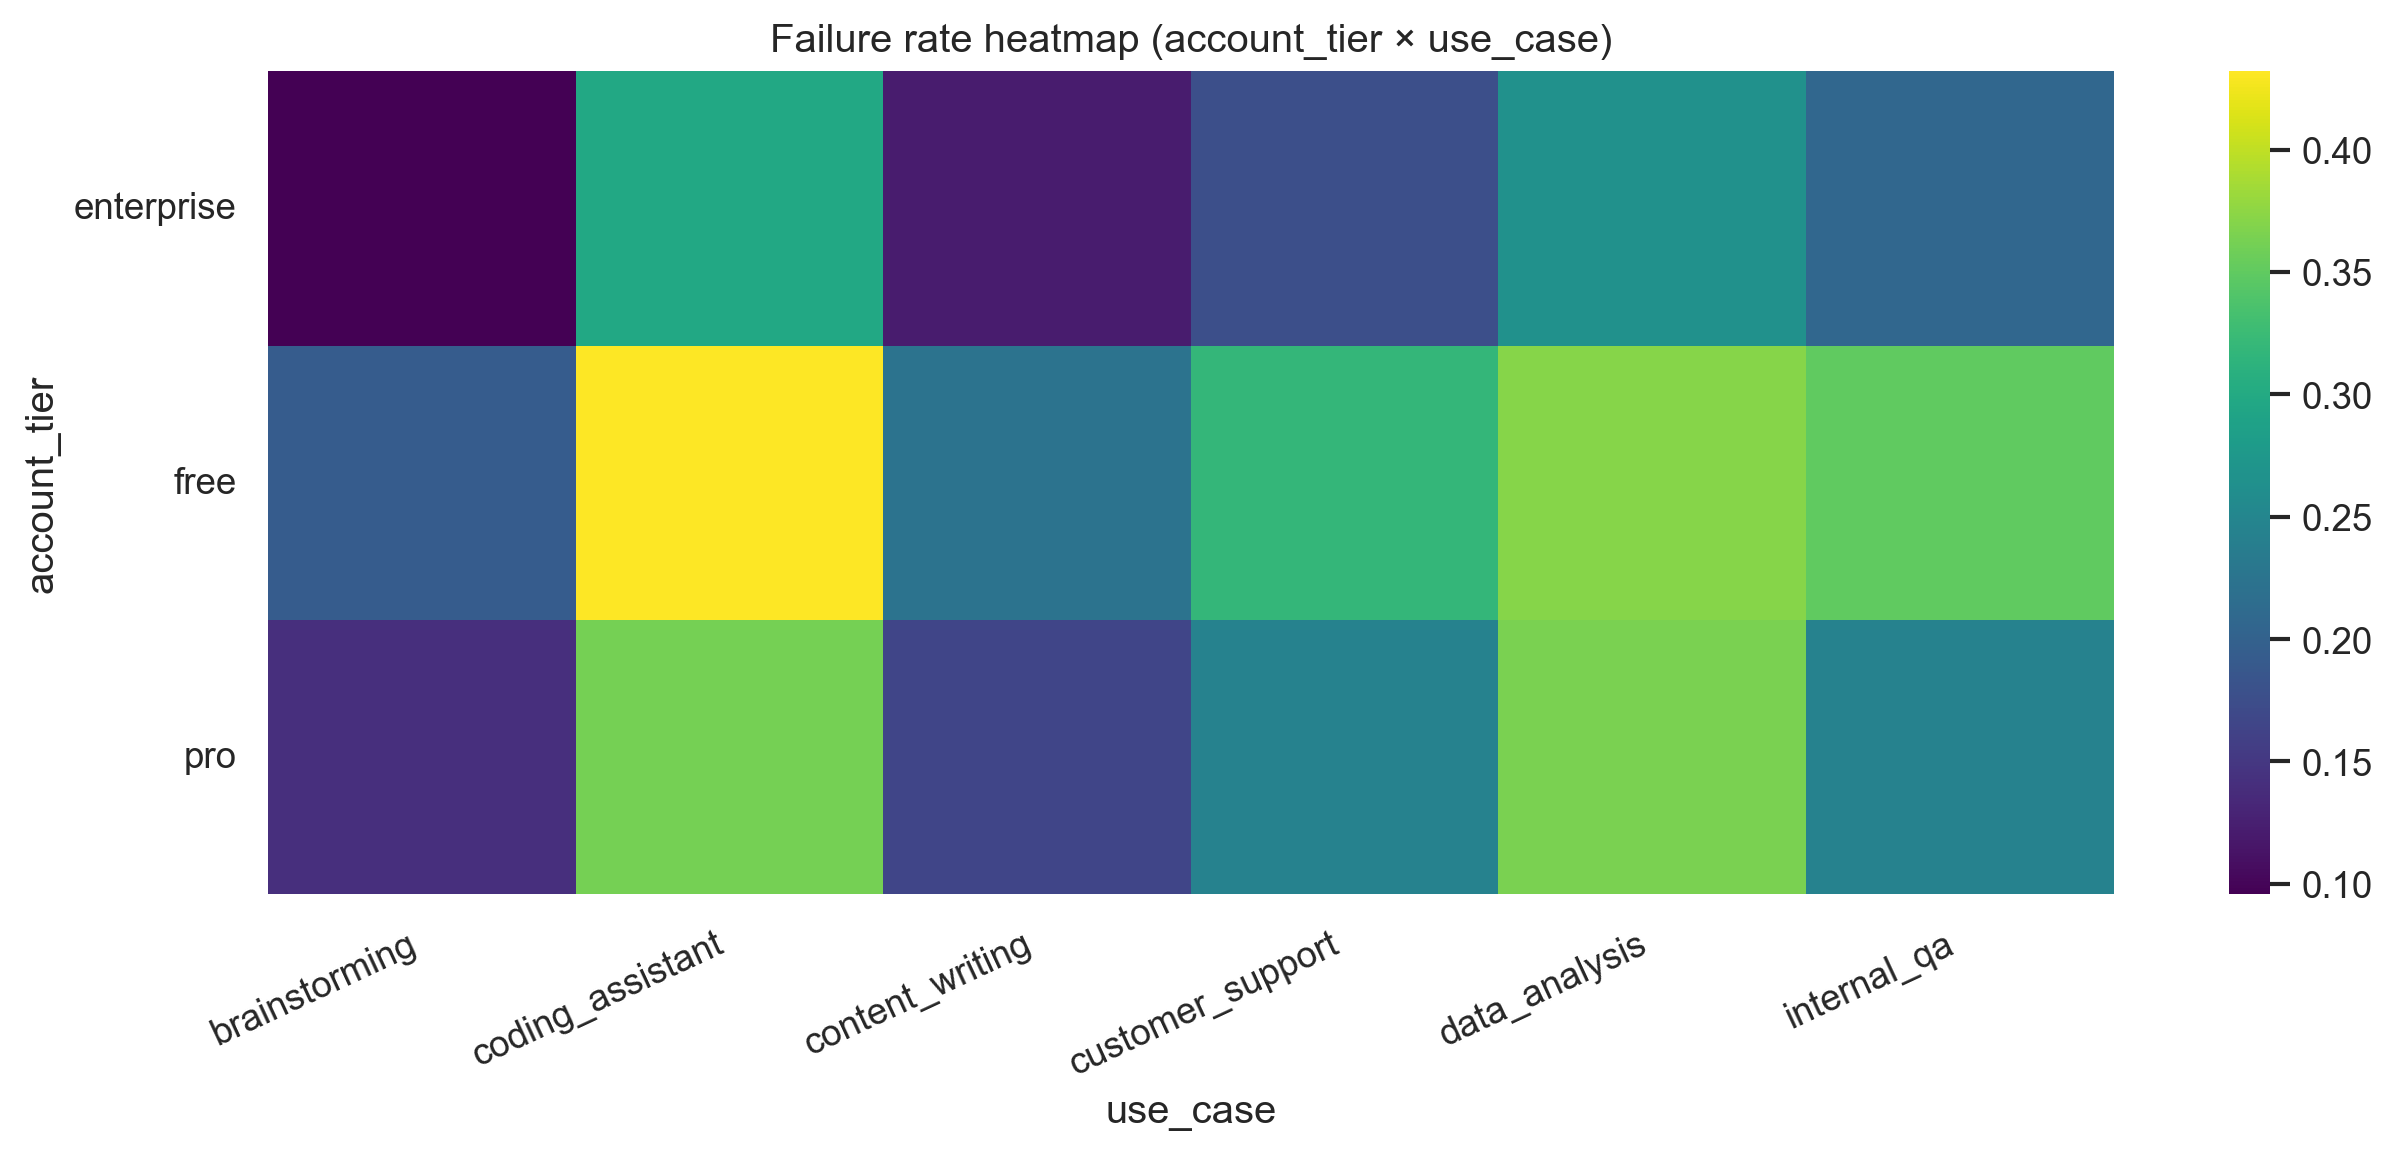

In [19]:
if len(train_hist) == 0:
    print("Skipped: no training history.")
else:
    base = train_hist.copy()
    for c in ["use_case", "account_tier"]:
        ensure_col(base, c, "unknown")

    s2 = base.groupby(["use_case", "account_tier"], as_index=False).agg(
        requests=("interaction_id", "size"),
        fail_rate=("is_failure", "mean"),
        p95_latency=("latency_ms", lambda x: q(x, 95)),
        avg_cost=("cost_usd", "mean"),
    )
    s2 = s2[s2["requests"] >= MIN_REQUESTS_SLICE].copy()

    if len(s2) == 0:
        print("Not enough volume for slices.")
    else:
        s2["heuristic_risk_score"] = (
            2.0 * s2["fail_rate"]
            + 0.5 * (s2["p95_latency"] / max(SLA_MS, 1))
            + 0.1 * s2["avg_cost"].fillna(0)
        )
        top = s2.sort_values("heuristic_risk_score", ascending=False).head(15)
        show_table(top, title="Top risk slices (historical)", max_rows=30)

        heat = s2.pivot(index="account_tier", columns="use_case", values="fail_rate")
        plt.figure(figsize=(11, 5))
        ax = sns.heatmap(heat, cmap="viridis", cbar=True)
        ax.set_title("Failure rate heatmap (account_tier × use_case)")
        plt.xticks(rotation=25, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

<h2 style="margin:24px 0 10px 0;">Provider/model hotspots</h2>
<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
<b>Routing intuition</b><br/>
A simple risk map: latency vs failure. Points right of the SLA line are latency risk; points above the failure line are reliability risk.
These hotspots become candidates for routing policy changes (or temporary bans).
</div>


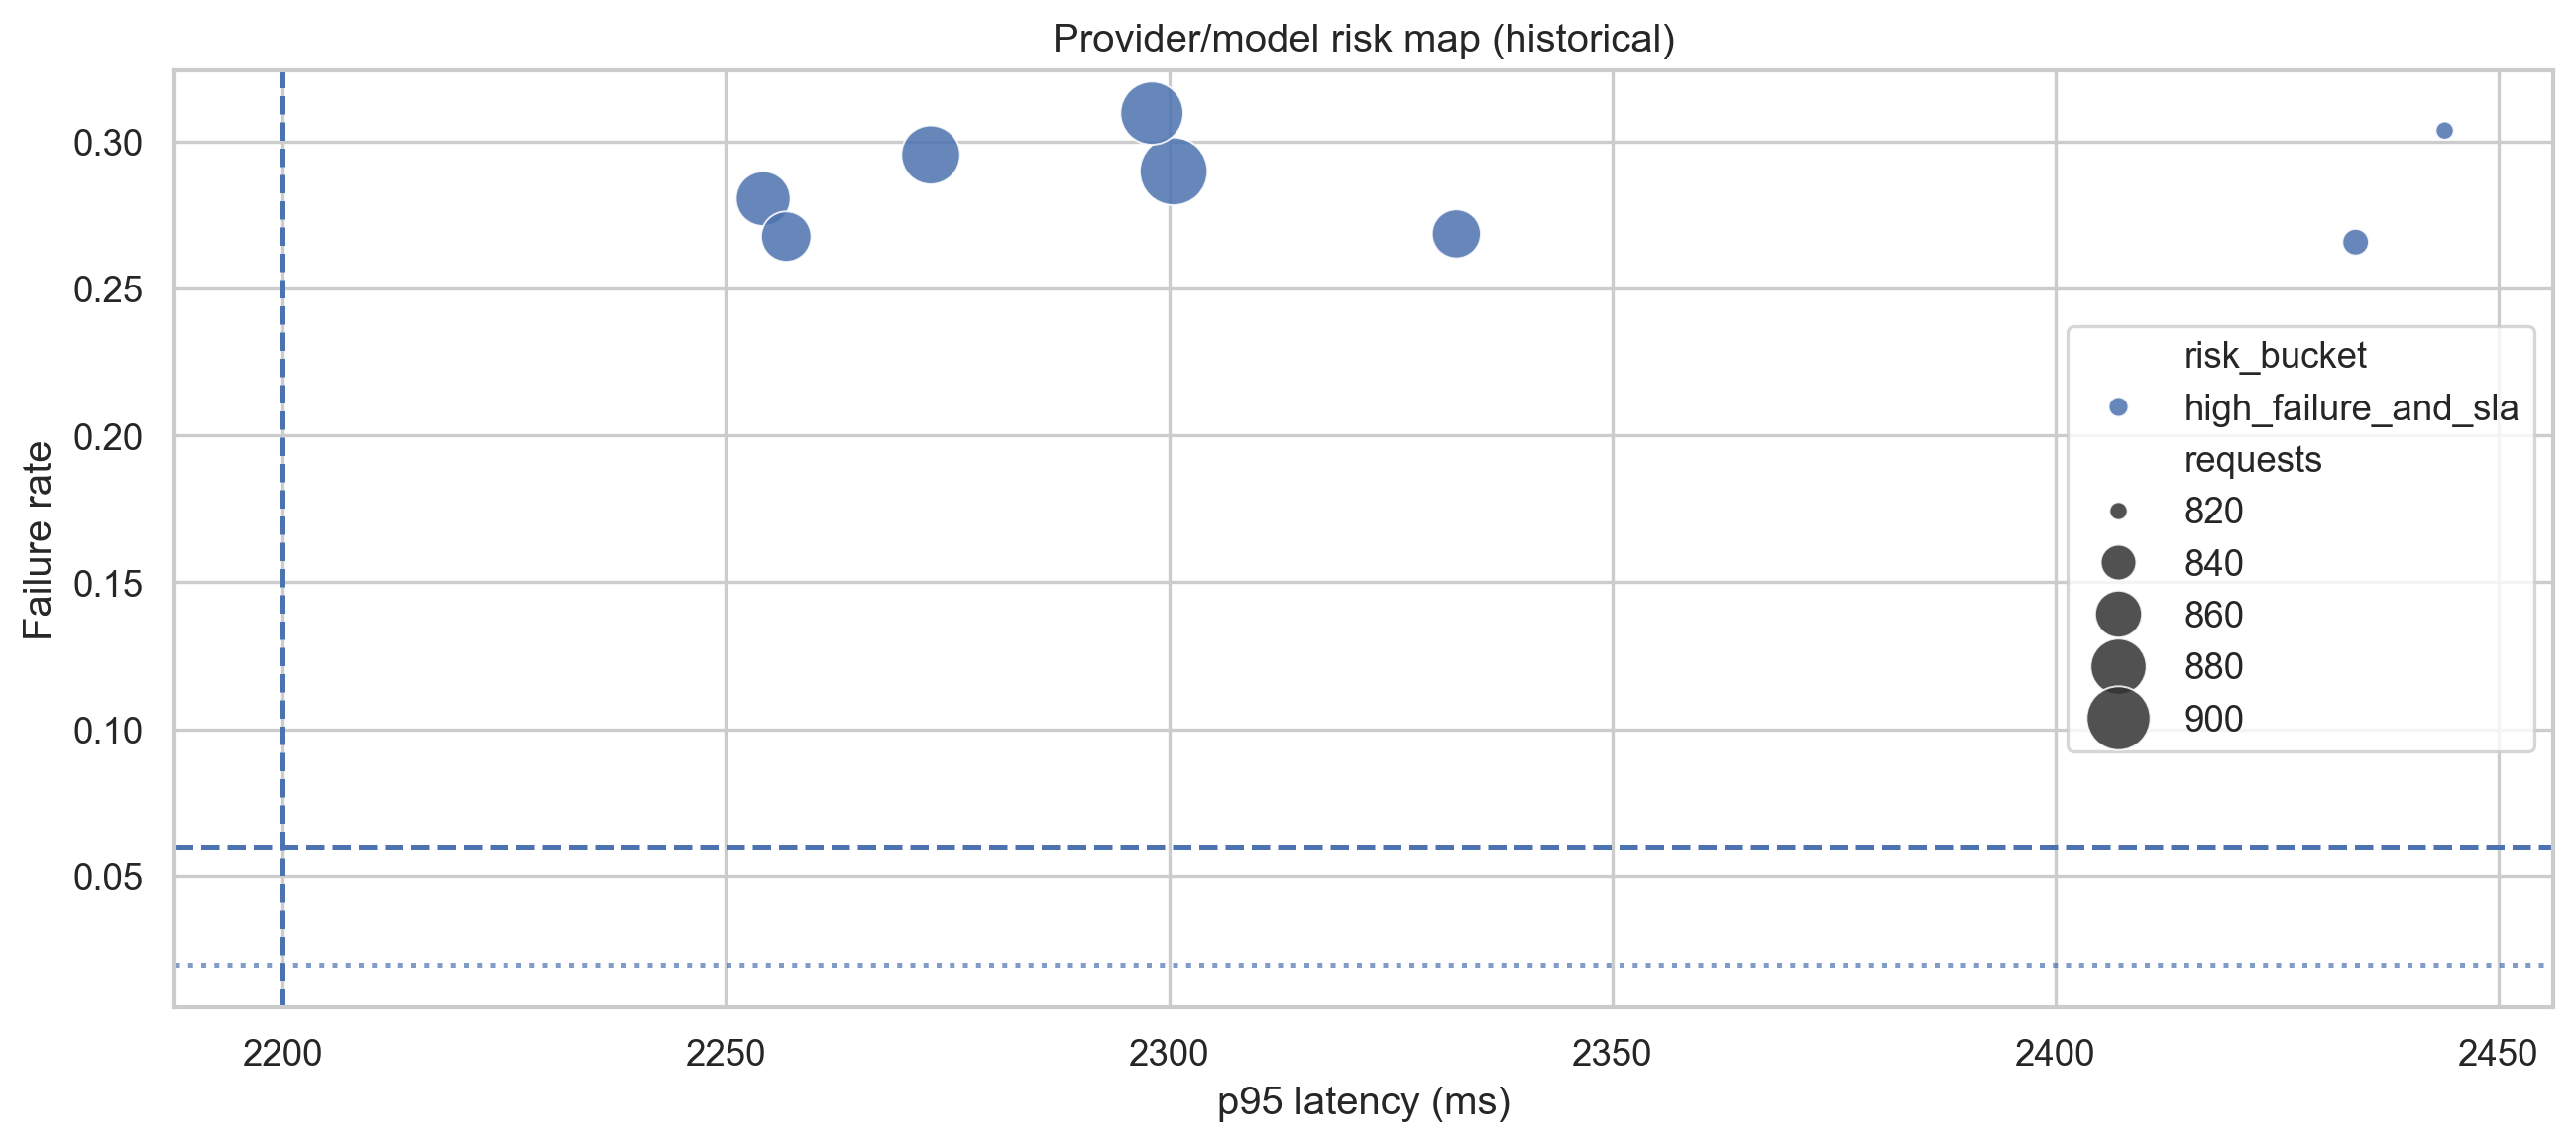

Provider/model hotspots (preview)


,model_provider,model_name,requests,fail_rate,p95_latency,cost_per_request,sla_breach_rate,risk_bucket
7,openai,gpt-4o-mini,911,0.289791,2300.50,0.021683,0.055982,high_failure_and_sla
2,local,custom-local-8b,898,0.309577,2298.05,0.004361,0.063474,high_failure_and_sla
1,google,gemini-1.5-pro,887,0.295378,2273.10,0.351354,0.058625,high_failure_and_sla
3,meta,llama-3.1-70b,877,0.280502,2254.20,0.219669,0.059293,high_failure_and_sla
5,mistral,mistral-large,867,0.267589,2256.80,0.132031,0.056517,high_failure_and_sla
4,meta,llama-3.1-8b,864,0.268519,2332.40,0.065551,0.067130,high_failure_and_sla
6,openai,gpt-4.1,828,0.265700,2433.85,0.436298,0.072464,high_failure_and_sla
0,anthropic,claude-3.5-sonnet,820,0.303659,2443.90,0.355529,0.070732,high_failure_and_sla


In [20]:
if len(train_hist) == 0:
    print("Skipped.")
else:
    pm = train_hist.groupby(["model_provider", "model_name"], as_index=False).agg(
        requests=("interaction_id", "size"),
        fail_rate=("is_failure", "mean"),
        p95_latency=("latency_ms", lambda x: q(x, 95)),
        cost_per_request=("cost_usd", "mean"),
        sla_breach_rate=("latency_ms", lambda x: breach_rate_non_null(x, SLA_MS)),
    )

    pm = pm[pm["requests"] >= MIN_REQUESTS_POLICY].copy()
    pm["risk_bucket"] = np.select(
        [
            (pm["fail_rate"] > HOTSPOT_FAIL_RATE) & (pm["p95_latency"] > SLA_MS),
            (pm["fail_rate"] > HOTSPOT_FAIL_RATE),
            (pm["p95_latency"] > SLA_MS),
        ],
        ["high_failure_and_sla", "high_failure", "sla_risk"],
        default="ok",
    )

    plot_df = pm.sort_values("requests", ascending=False).head(30)
    plt.figure(figsize=(11, 5))
    ax = sns.scatterplot(
        data=plot_df,
        x="p95_latency",
        y="fail_rate",
        hue="risk_bucket",
        size="requests",
        sizes=(30, 420),
        alpha=0.85,
    )
    ax.axvline(SLA_MS, linestyle="--")
    ax.axhline(HOTSPOT_FAIL_RATE, linestyle="--")
    ax.axhline(FAIL_BUDGET, linestyle=":", alpha=0.7)
    ax.set_title("Provider/model risk map (historical)")
    ax.set_xlabel("p95 latency (ms)")
    ax.set_ylabel("Failure rate")
    plt.tight_layout()
    plt.show()

    show_table(
        pm.sort_values(["risk_bucket", "requests"], ascending=[True, False]).head(15),
        title="Provider/model hotspots (preview)",
        max_rows=15,
    )

<h2 style='margin:22px 0 10px 0;'>4) Routing policy + backtest</h2>

<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
  <b>Selection bias disclaimer (read this)</b><br/>
  This is an <b>offline observational backtest</b>. It does not prove causality.<br/>
  Provider/model performance is measured on the traffic that actually reached it, which can be biased by the current routing,
  prompt mix, user segments, tool usage, or incident handling.<br/><br/>
  Treat the routing output as a <b>candidate policy</b>. Validate with <b>shadow routing</b>, <b>A/B tests</b>, or controlled rollouts.
</div>


In [21]:
policy_path = OUT_DIR / "routing_policy_use_case.csv"


def _pick_best(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    return (
        df.sort_values(
            ["use_case", "expected_unit_cost", "p95_latency", "requests"],
            ascending=[True, True, True, False],
        )
        .groupby("use_case", as_index=False)
        .first()
    )


def build_policy_relaxed(
    sla_ms: float,
    max_fail: float,
    failure_business_cost: float,
    sla_breach_penalty_usd: float,
    min_req: int = MIN_REQUESTS_POLICY,
) -> pd.DataFrame:
    grp_train = train_hist.groupby(
        ["use_case", "model_provider", "model_name"], as_index=False
    ).agg(
        requests=("interaction_id", "size"),
        fail_rate=("is_failure", "mean"),
        avg_cost=("cost_usd", "mean"),
        p95_latency=("latency_ms", lambda x: q(x, 95)),
        sla_breach_rate=("latency_ms", lambda x: breach_rate_non_null(x, sla_ms)),
    )

    base = grp_train[grp_train["requests"] >= min_req].copy()

    base["fail_rate"] = pd.to_numeric(base["fail_rate"], errors="coerce")
    base["avg_cost"] = pd.to_numeric(base["avg_cost"], errors="coerce")
    base["p95_latency"] = pd.to_numeric(base["p95_latency"], errors="coerce")
    base["sla_breach_rate"] = pd.to_numeric(base["sla_breach_rate"], errors="coerce")
    base = base.dropna(subset=["fail_rate", "avg_cost", "p95_latency"])

    if base.empty:
        return base

    base["expected_unit_cost"] = (
        base["avg_cost"]
        + base["fail_rate"].clip(0, 1) * float(failure_business_cost)
        + base["sla_breach_rate"].fillna(0).clip(0, 1) * float(sla_breach_penalty_usd)
    )

    strict = base[(base["p95_latency"] <= sla_ms) & (base["fail_rate"] <= max_fail)].copy()
    strict_best = _pick_best(strict)
    strict_best["policy_mode"] = "strict"

    covered = set(strict_best["use_case"].unique())
    remaining = sorted(set(base["use_case"].unique()) - covered)
    picks = [strict_best] if len(strict_best) else []

    relax_steps = [
        ("relax_1", sla_ms * 1.15, max_fail + 0.05),
        ("relax_2", sla_ms * 1.30, max_fail + 0.10),
    ]
    for mode, sla2, f2 in relax_steps:
        if not remaining:
            break
        cand = base[base["use_case"].isin(remaining)].copy()
        cand = cand[(cand["p95_latency"] <= sla2) & (cand["fail_rate"] <= f2)].copy()
        best = _pick_best(cand)
        if len(best):
            best["policy_mode"] = mode
            picks.append(best)
            covered |= set(best["use_case"].unique())
            remaining = sorted(set(base["use_case"].unique()) - covered)

    if remaining:
        fallback = _pick_best(base[base["use_case"].isin(remaining)].copy())
        if len(fallback):
            fallback["policy_mode"] = "fallback_unconstrained"
            picks.append(fallback)

    out = pd.concat(picks, ignore_index=True) if picks else pd.DataFrame()
    cols = [
        "use_case",
        "model_provider",
        "model_name",
        "requests",
        "fail_rate",
        "p95_latency",
        "sla_breach_rate",
        "avg_cost",
        "expected_unit_cost",
        "policy_mode",
    ]
    return out[cols].sort_values("use_case") if len(out) else out


if len(train_hist) == 0 or len(test_future) == 0 or "use_case" not in train_hist.columns:
    pd.DataFrame(
        columns=[
            "use_case",
            "model_provider",
            "model_name",
            "requests",
            "fail_rate",
            "p95_latency",
            "sla_breach_rate",
            "avg_cost",
            "expected_unit_cost",
            "policy_mode",
        ]
    ).to_csv(policy_path, index=False)
    print("Routing skipped: missing train/test window or use_case.")
else:
    policy = build_policy_relaxed(
        sla_ms=SLA_MS,
        max_fail=ROUTING_MAX_FAIL_RATE,
        failure_business_cost=FAILURE_EVENT_COST_USD,
        sla_breach_penalty_usd=SLA_BREACH_PENALTY_USD,
    )
    policy.to_csv(policy_path, index=False, encoding="utf-8")

    uc_base_test = test_future.groupby("use_case", as_index=False).agg(
        requests=("interaction_id", "size"),
        baseline_fail_rate=("is_failure", "mean"),
        baseline_avg_cost=("cost_usd", "mean"),
        baseline_p95_latency=("latency_ms", lambda x: q(x, 95)),
        baseline_sla_breach_rate=("latency_ms", lambda x: breach_rate_non_null(x, SLA_MS)),
    )

    combo_test = test_future.groupby(
        ["use_case", "model_provider", "model_name"], as_index=False
    ).agg(
        fail_rate=("is_failure", "mean"),
        avg_cost=("cost_usd", "mean"),
        p95_latency=("latency_ms", lambda x: q(x, 95)),
        sla_breach_rate=("latency_ms", lambda x: breach_rate_non_null(x, SLA_MS)),
    )

    m = uc_base_test.merge(
        policy[["use_case", "model_provider", "model_name", "policy_mode"]],
        on="use_case",
        how="left",
    )
    m = m.merge(combo_test, on=["use_case", "model_provider", "model_name"], how="left")

    m["covered_by_policy"] = m["model_name"].notna()

    for col, base_col in [
        ("fail_rate", "baseline_fail_rate"),
        ("avg_cost", "baseline_avg_cost"),
        ("p95_latency", "baseline_p95_latency"),
        ("sla_breach_rate", "baseline_sla_breach_rate"),
    ]:
        m[col] = pd.to_numeric(m[col], errors="coerce").fillna(
            pd.to_numeric(m[base_col], errors="coerce")
        )

    req_total = float(m["requests"].sum()) if "requests" in m.columns else float("nan")

    missing_any = m[["fail_rate", "avg_cost", "p95_latency"]].isna().any(axis=1)
    missing_share_requests = (
        float(m.loc[missing_any, "requests"].sum() / req_total) if req_total else 0.0
    )
    if missing_share_requests > 0:
        raise ValueError(
            f"Stop-ship: routing backtest has missing metrics for {missing_share_requests:.2%} of requests "
            "(after baseline fill). Provide cost/latency coverage or estimate them before using routing outputs."
        )

    m["baseline_expected_unit_cost"] = (
        pd.to_numeric(m["baseline_avg_cost"], errors="coerce")
        + pd.to_numeric(m["baseline_fail_rate"], errors="coerce").clip(0, 1)
        * FAILURE_EVENT_COST_USD
        + pd.to_numeric(m["baseline_sla_breach_rate"], errors="coerce").fillna(0).clip(0, 1)
        * SLA_BREACH_PENALTY_USD
    )
    m["policy_expected_unit_cost"] = (
        pd.to_numeric(m["avg_cost"], errors="coerce")
        + pd.to_numeric(m["fail_rate"], errors="coerce").clip(0, 1) * FAILURE_EVENT_COST_USD
        + pd.to_numeric(m["sla_breach_rate"], errors="coerce").fillna(0).clip(0, 1)
        * SLA_BREACH_PENALTY_USD
    )

    covered_uc = (
        int(m.loc[m["covered_by_policy"], "use_case"].nunique()) if "use_case" in m.columns else 0
    )

    impact = pd.DataFrame(
        [
            {
                "evaluation_window": "split == 'test'"
                if ("split" in df_time.columns)
                else f"timestamp_utc > {str(cut_ts)}",
                "requests": int(m["requests"].sum()),
                "use_cases_total": int(m["use_case"].nunique()),
                "use_cases_covered": covered_uc,
                "baseline_expected_fail_rate": float(
                    (m["requests"] * m["baseline_fail_rate"]).sum() / m["requests"].sum()
                ),
                "policy_expected_fail_rate": float(
                    (m["requests"] * m["fail_rate"]).sum() / m["requests"].sum()
                ),
                "baseline_expected_unit_cost": float(
                    (m["requests"] * m["baseline_expected_unit_cost"]).sum() / m["requests"].sum()
                ),
                "policy_expected_unit_cost": float(
                    (m["requests"] * m["policy_expected_unit_cost"]).sum() / m["requests"].sum()
                ),
                "baseline_total_expected_cost": float(
                    (m["requests"] * m["baseline_expected_unit_cost"]).sum()
                ),
                "policy_total_expected_cost": float(
                    (m["requests"] * m["policy_expected_unit_cost"]).sum()
                ),
                "routing_max_fail_rate": float(ROUTING_MAX_FAIL_RATE),
                "failure_business_cost": float(FAILURE_EVENT_COST_USD),
                "sla_breach_penalty_usd": float(SLA_BREACH_PENALTY_USD),
            }
        ]
    )

    show_table(impact, title="Routing backtest summary (observational)", max_rows=50)
    print("Saved:", policy_path)

Routing backtest summary (observational)


,evaluation_window,requests,use_cases_total,use_cases_covered,baseline_expected_fail_rate,policy_expected_fail_rate,baseline_expected_unit_cost,policy_expected_unit_cost,baseline_total_expected_cost,policy_total_expected_cost,routing_max_fail_rate,failure_business_cost,sla_breach_penalty_usd
0,split == 'test',1007,6,6,0.298908,0.302653,12.473376,12.640835,12560.68956,12729.321005,0.12,40.0,5.0


Saved: artifacts\routing_policy_use_case.csv


<h2 style='margin:22px 0 10px 0;'>5) Drift report</h2>


In [22]:
drift_path = OUT_DIR / "drift_report.csv"


def psi(expected: np.ndarray, actual: np.ndarray, bins: int = 10) -> float:
    expected = np.asarray(expected, dtype=float)
    actual = np.asarray(actual, dtype=float)
    expected = expected[np.isfinite(expected)]
    actual = actual[np.isfinite(actual)]
    if len(expected) < 50 or len(actual) < 50:
        return float("nan")

    edges = np.quantile(expected, np.linspace(0, 1, bins + 1))
    edges = np.asarray(edges, dtype=float)
    edges[0] = min(edges[0], float(np.min(actual)))
    edges[-1] = max(edges[-1], float(np.max(actual)))
    edges = np.unique(edges)
    if len(edges) < 3:
        return float("nan")

    e_hist, _ = np.histogram(expected, bins=edges)
    a_hist, _ = np.histogram(actual, bins=edges)

    e = e_hist / max(e_hist.sum(), 1)
    a = a_hist / max(a_hist.sum(), 1)

    eps = 1e-6
    e = np.clip(e, eps, 1)
    a = np.clip(a, eps, 1)
    return float(np.sum((a - e) * np.log(a / e)))


def tv_distance(p: pd.Series, q_: pd.Series) -> float:
    idx = p.index.union(q_.index)
    p2 = p.reindex(idx, fill_value=0).astype(float)
    q2 = q_.reindex(idx, fill_value=0).astype(float)
    return float(0.5 * np.abs(p2 - q2).sum())


if len(train_hist) == 0 or len(test_future) == 0:
    pd.DataFrame().to_csv(drift_path, index=False)
    print("Drift skipped.")
else:
    num_cols = [
        c
        for c in [
            "latency_ms",
            "cost_usd",
            "total_tokens",
            "prompt_tokens",
            "completion_tokens",
            "tool_calls_count",
            "response_quality_score",
            "tokens_per_second",
            "prompt_to_completion_ratio",
        ]
        if c in df_time.columns
    ]
    cat_cols = [
        c
        for c in [
            "model_provider",
            "model_name",
            "use_case",
            "channel",
            "account_tier",
            "region",
            "segment",
        ]
        if c in df_time.columns
    ]

    rows = []
    for c in num_cols:
        rows.append(
            {
                "feature": c,
                "type": "numeric",
                "psi": psi(train_hist[c].values, test_future[c].values, bins=10),
                "tv_distance": np.nan,
            }
        )
    for c in cat_cols:
        p = train_hist[c].astype(str).value_counts(normalize=True)
        qv = test_future[c].astype(str).value_counts(normalize=True)
        rows.append(
            {"feature": c, "type": "categorical", "psi": np.nan, "tv_distance": tv_distance(p, qv)}
        )

    drift = pd.DataFrame(rows)

    drift["psi"] = pd.to_numeric(drift["psi"], errors="coerce")
    drift["tv_distance"] = pd.to_numeric(drift["tv_distance"], errors="coerce")

    severity = np.full(len(drift), "", dtype=object)

    psi_v = drift["psi"].to_numpy(dtype=float)
    tv_v = drift["tv_distance"].to_numpy(dtype=float)
    is_num = drift["type"].to_numpy(dtype=str) == "numeric"
    is_cat = ~is_num

    m = is_num & np.isfinite(psi_v)
    severity[m & (psi_v >= 0.2)] = "high"
    severity[m & (psi_v >= 0.1) & (psi_v < 0.2)] = "medium"

    m = is_cat & np.isfinite(tv_v)
    severity[m & (tv_v >= 0.15)] = "high"
    severity[m & (tv_v >= 0.08) & (tv_v < 0.15)] = "medium"

    drift["severity"] = severity
    sev_rank = {"high": 2, "medium": 1, "": 0}
    drift["sev_rank"] = drift["severity"].map(sev_rank).fillna(0).astype(int)
    drift = drift.sort_values(
        ["sev_rank", "psi", "tv_distance"], ascending=[False, False, False]
    ).drop(columns=["sev_rank"])
    drift.to_csv(drift_path, index=False, encoding="utf-8")

    hi = drift[drift["severity"].isin(["high", "medium"])].head(20)
    show_table(hi, title="Drift highlights (medium/high)", max_rows=50)
    print("Saved:", drift_path)

Drift highlights (medium/high)


,feature,type,psi,tv_distance,severity


Saved: artifacts\drift_report.csv


<h2 style='margin:22px 0 10px 0;'>6) Triage threshold (calibrated risk × capacity)</h2>


Failure-triage model metrics (evaluation window)


,metric,value
0,roc_auc,0.614138
1,avg_precision,0.371933
2,test_base_rate,0.298908
3,test_size,1007.000000


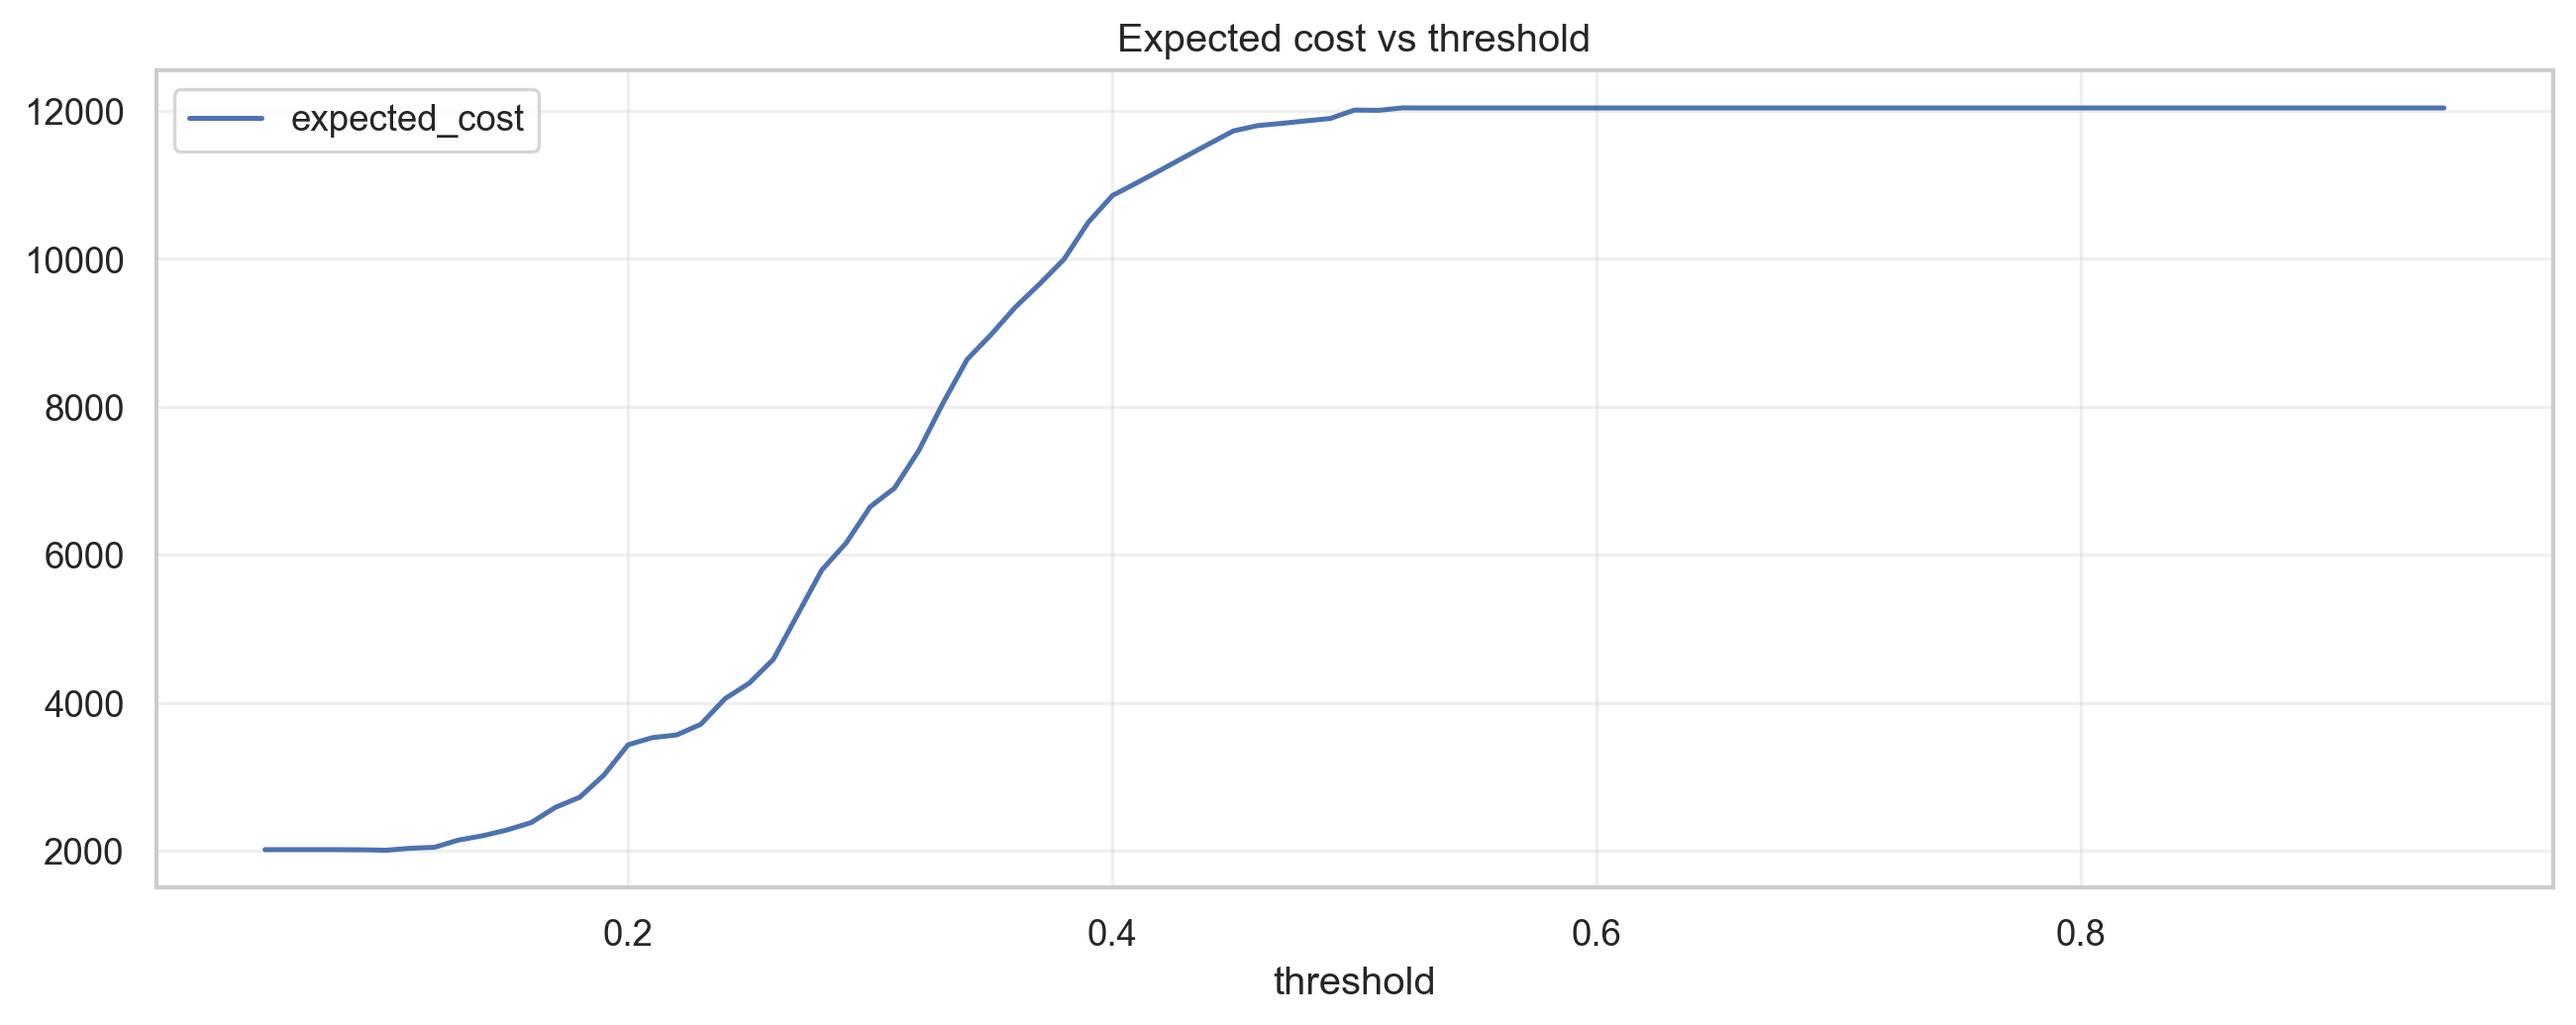

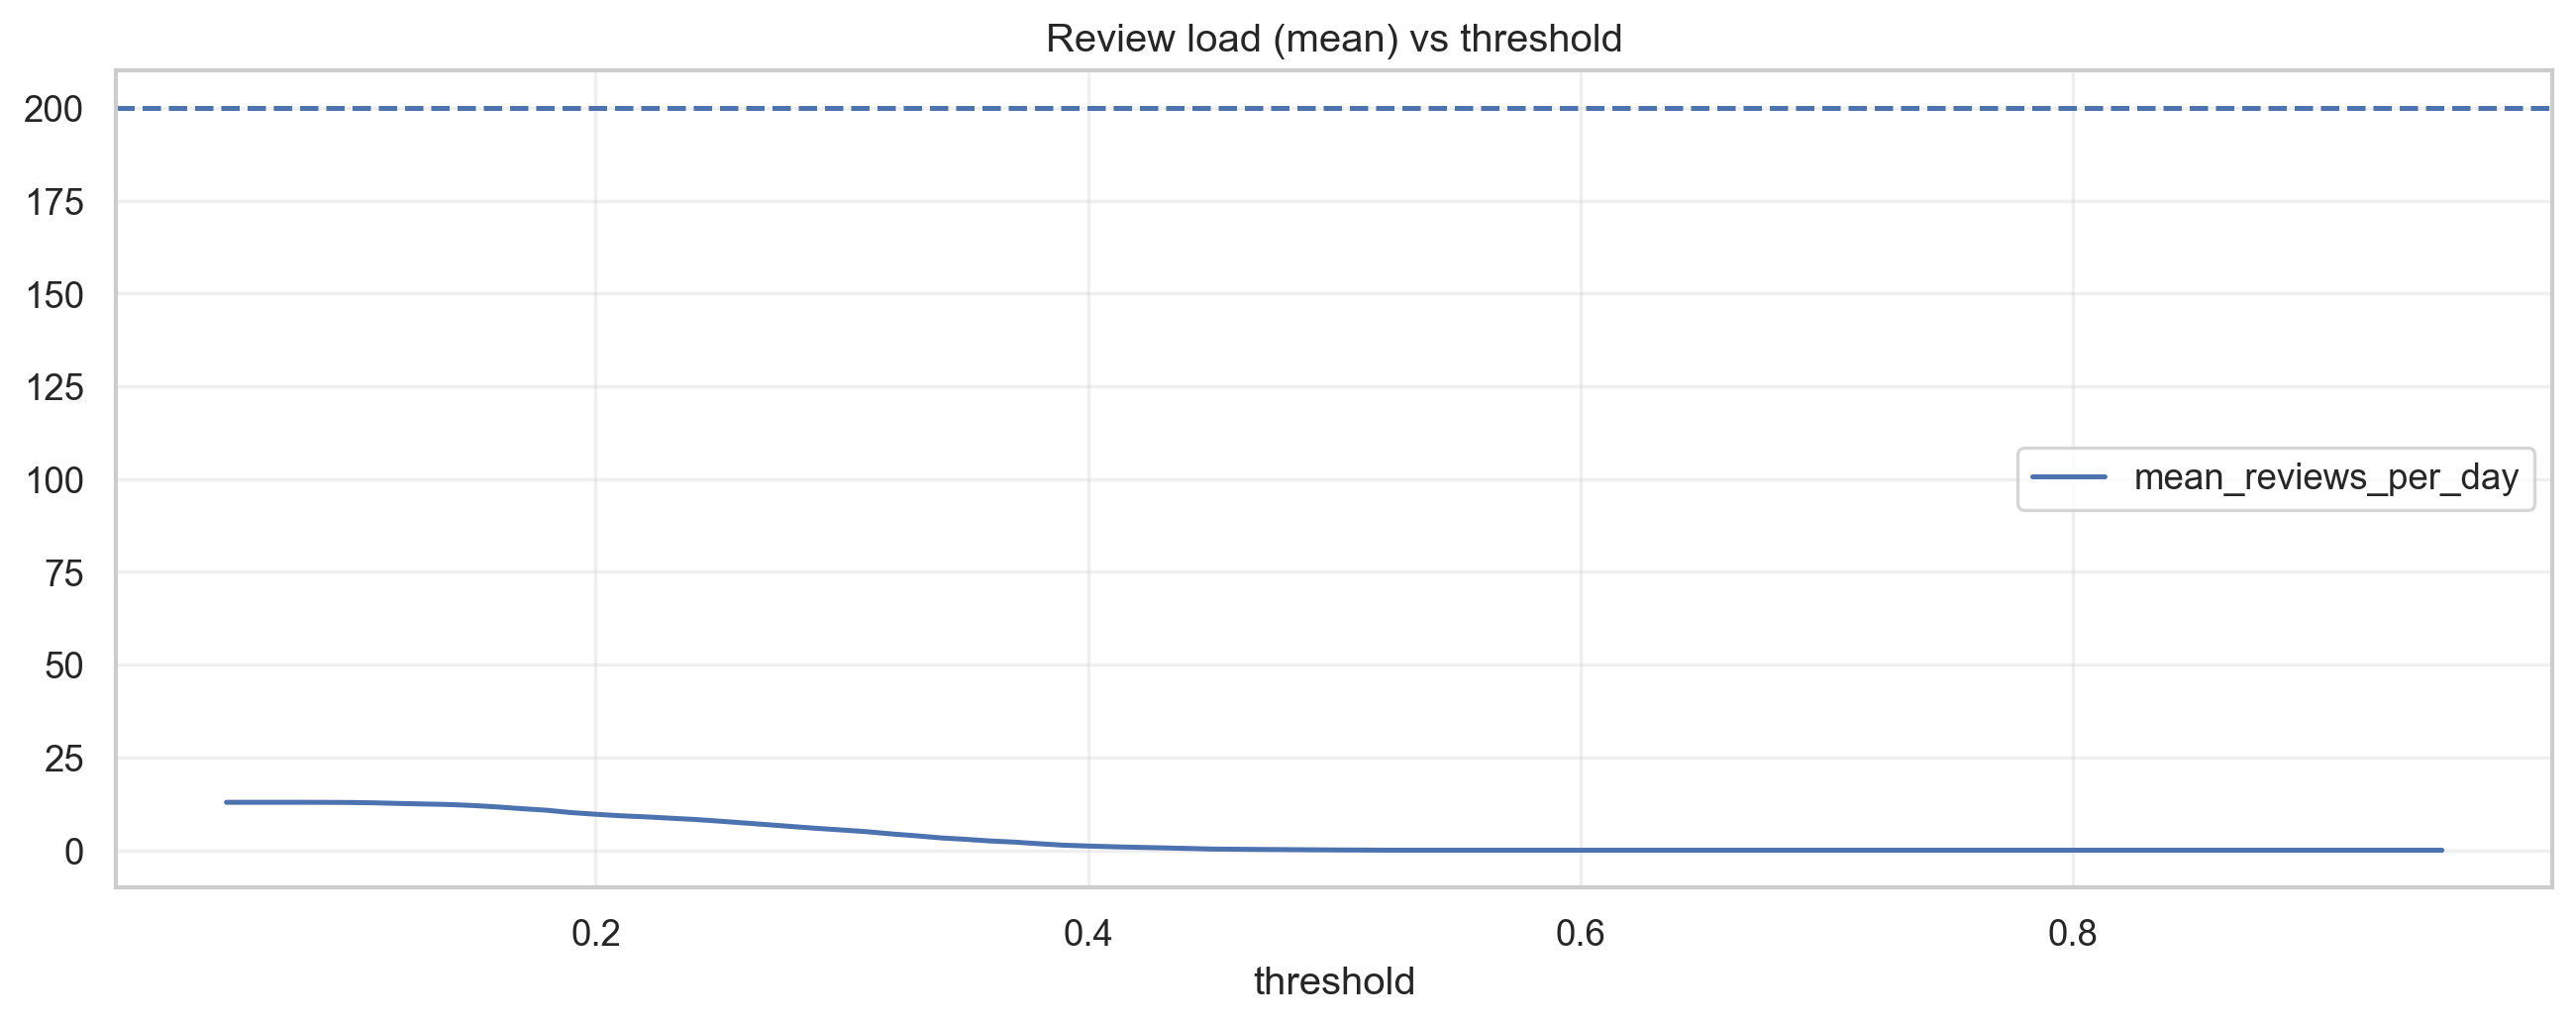

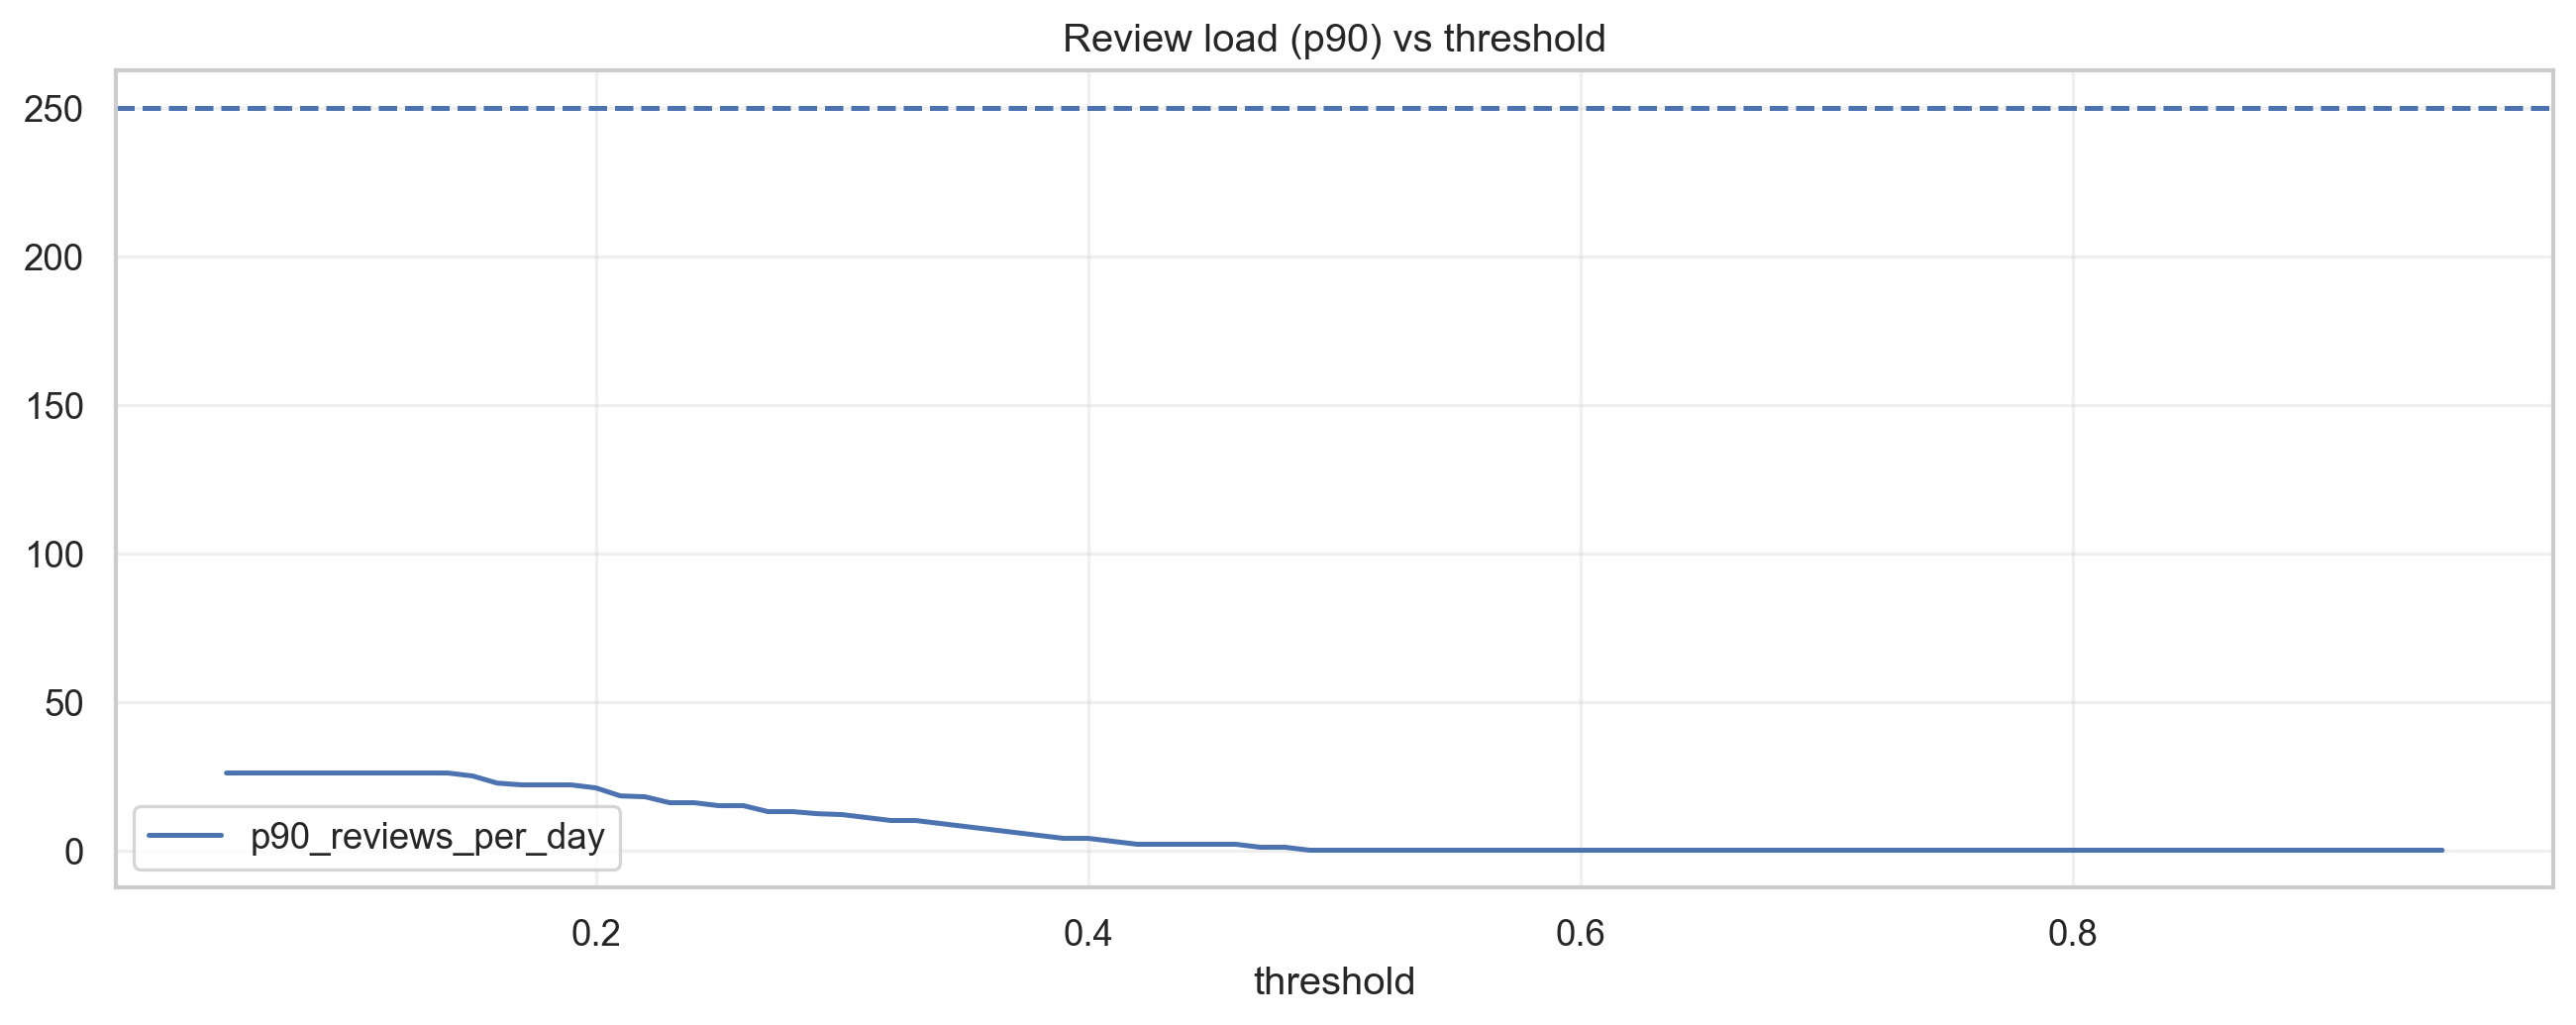

Chosen threshold performance (evaluation window)


,metric,value
0,threshold,0.1000
1,tn,4.0000
2,fp,702.0000
3,fn,0.0000
4,tp,301.0000
5,precision,0.3001
6,recall,1.0000


Saved: artifacts\triage_threshold_policy.json artifacts\triage_actions_preview.csv


In [23]:
triage_json = OUT_DIR / "triage_threshold_policy.json"
triage_preview = OUT_DIR / "triage_actions_preview.csv"

if len(train_hist) == 0 or len(test_future) == 0 or "is_failure" not in df_time.columns:
    triage_json.write_text(
        json.dumps({"status": "skipped", "reason": "missing_windows_or_target"}, indent=2),
        encoding="utf-8",
    )
    pd.DataFrame(columns=["interaction_id", "proba_failure", "action_review"]).to_csv(
        triage_preview, index=False
    )
    print("Triage skipped.")
else:
    train_df = train_hist.sort_values("timestamp_utc").copy()
    test_df = test_future.sort_values("timestamp_utc").copy()

    y_train = pd.to_numeric(train_df["is_failure"], errors="coerce").fillna(0).astype(int)
    y_test = pd.to_numeric(test_df["is_failure"], errors="coerce").fillna(0).astype(int)

    NUM = [
        c
        for c in [
            "latency_ms",
            "prompt_tokens",
            "completion_tokens",
            "total_tokens",
            "cost_usd",
            "tool_calls_count",
            "tokens_per_second",
            "prompt_to_completion_ratio",
        ]
        if c in train_df.columns
    ]
    CAT = [
        c
        for c in [
            "model_provider",
            "model_name",
            "use_case",
            "channel",
            "account_tier",
            "region",
            "segment",
        ]
        if c in train_df.columns
    ]

    if len(NUM) == 0 and len(CAT) == 0:
        triage_json.write_text(
            json.dumps({"status": "skipped", "reason": "missing_feature_columns"}, indent=2),
            encoding="utf-8",
        )
        pd.DataFrame(columns=["interaction_id", "proba_failure", "action_review"]).to_csv(
            triage_preview, index=False
        )
        print("Triage skipped: missing features.")
    elif y_train.nunique() < 2 or y_test.nunique() < 2:
        triage_json.write_text(
            json.dumps({"status": "skipped", "reason": "insufficient_class_variety"}, indent=2),
            encoding="utf-8",
        )
        pd.DataFrame(columns=["interaction_id", "proba_failure", "action_review"]).to_csv(
            triage_preview, index=False
        )
        print("Triage skipped: insufficient class variety.")
    else:
        X_train = train_df[NUM + CAT].copy()
        X_test = test_df[NUM + CAT].copy()

        for c in NUM:
            X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
            X_test[c] = pd.to_numeric(X_test[c], errors="coerce")

        cal_source = (
            "val_split" if ("val_window" in globals() and len(val_window)) else "train_tail_15pct"
        )

        ps = None
        cal_cut_ts = None
        X_cal = None
        y_cal = None

        if cal_source == "val_split":
            X_cal = val_window[NUM + CAT].copy()
            y_cal = pd.to_numeric(val_window["is_failure"], errors="coerce").fillna(0).astype(int)
        else:
            train_ts = pd.to_datetime(train_df["timestamp_utc"], utc=True, errors="coerce")
            cal_cut_ts = train_ts.quantile(0.85)

            cal_mask = (train_ts > cal_cut_ts).to_numpy()
            test_fold = np.where(cal_mask, 0, -1)
            ps = PredefinedSplit(test_fold)

        transformers = []
        if len(NUM):
            num_pipe = Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            )
            transformers.append(("num", num_pipe, NUM))

        if len(CAT):
            cat_pipe = Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("ohe", OneHotEncoder(handle_unknown="ignore")),
                ]
            )
            transformers.append(("cat", cat_pipe, CAT))

        pre = ColumnTransformer(transformers)

        base = Pipeline(
            [
                ("pre", pre),
                (
                    "clf",
                    LogisticRegression(
                        solver="saga",
                        max_iter=5000,
                        n_jobs=-1,
                        tol=1e-3,
                        class_weight="balanced",
                        random_state=RANDOM_SEED,
                    ),
                ),
            ]
        )

        if cal_source == "val_split":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                base.fit(X_train, y_train)

            est = FrozenEstimator(base) if FrozenEstimator is not None else base
            cal = CalibratedClassifierCV(est, method="sigmoid")

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                cal.fit(X_cal, y_cal)
        else:
            cal = CalibratedClassifierCV(base, method="sigmoid", cv=ps)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                cal.fit(X_train, y_train)

        proba = cal.predict_proba(X_test)[:, 1]

        metrics = {
            "roc_auc": float(roc_auc_score(y_test, proba)),
            "avg_precision": float(average_precision_score(y_test, proba)),
            "test_base_rate": float(y_test.mean()),
            "test_size": int(len(y_test)),
        }
        metrics_df = pd.DataFrame({"metric": list(metrics.keys()), "value": list(metrics.values())})
        show_table(
            metrics_df, title="Failure-triage model metrics (evaluation window)", max_rows=20
        )

        days = (
            pd.to_datetime(test_df["timestamp_utc"], utc=True, errors="coerce").dt.floor("D").values
        )
        ths = np.linspace(0.05, 0.95, 91)

        rows = []
        for th in ths:
            pred = (proba >= th).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, pred, labels=[0, 1]).ravel()

            expected_cost = (tp + fp) * REVIEW_COST + fn * TRIAGE_FN_COST_USD

            tmp = pd.DataFrame({"day": days, "review": pred})
            day_sum = tmp.groupby("day")["review"].sum()
            mean_reviews = float(day_sum.mean())
            p90_reviews = float(np.percentile(day_sum.values, 90)) if len(day_sum) else float("nan")

            feasible = (mean_reviews <= CAPACITY_PER_DAY) and (p90_reviews <= CAPACITY_P90_GUARD)
            rows.append((th, expected_cost, mean_reviews, p90_reviews, feasible, tn, fp, fn, tp))

        cost_df = pd.DataFrame(
            rows,
            columns=[
                "threshold",
                "expected_cost",
                "mean_reviews_per_day",
                "p90_reviews_per_day",
                "feasible",
                "tn",
                "fp",
                "fn",
                "tp",
            ],
        )

        feasible_df = cost_df[cost_df["feasible"]]
        best = (
            feasible_df.sort_values("expected_cost").head(1)
            if len(feasible_df)
            else cost_df.sort_values("expected_cost").head(1)
        )
        best_th = float(best["threshold"].iloc[0])

        line_chart(cost_df, x="threshold", ys=["expected_cost"], title="Expected cost vs threshold")
        line_chart(
            cost_df,
            x="threshold",
            ys=["mean_reviews_per_day"],
            title="Review load (mean) vs threshold",
            hlines=[(CAPACITY_PER_DAY, "--")],
        )
        line_chart(
            cost_df,
            x="threshold",
            ys=["p90_reviews_per_day"],
            title="Review load (p90) vs threshold",
            hlines=[(CAPACITY_P90_GUARD, "--")],
        )

        triage_json.write_text(
            json.dumps(
                {
                    "status": "ok",
                    "label_definition": "is_failure (post-call failure triage)",
                    "threshold": best_th,
                    "time_split": {
                        "windowing_method": "dataset_split"
                        if ("split" in df_time.columns)
                        else "session_safe_time_split",
                        "history_start_timestamp_utc": str(train_hist["timestamp_utc"].min())
                        if len(train_hist)
                        else None,
                        "history_end_timestamp_utc": str(train_hist["timestamp_utc"].max())
                        if len(train_hist)
                        else None,
                        "calibration_source": cal_source,
                        "calibration_start_timestamp_utc": str(val_window["timestamp_utc"].min())
                        if (cal_source == "val_split" and len(val_window))
                        else (str(train_df["timestamp_utc"].min()) if len(train_df) else None),
                        "calibration_end_timestamp_utc": str(val_window["timestamp_utc"].max())
                        if (cal_source == "val_split" and len(val_window))
                        else (str(cal_cut_ts) if cal_cut_ts is not None else None),
                        "evaluation_start_timestamp_utc": str(test_future["timestamp_utc"].min())
                        if len(test_future)
                        else None,
                        "evaluation_end_timestamp_utc": str(test_future["timestamp_utc"].max())
                        if len(test_future)
                        else None,
                    },
                    "features_num": NUM,
                    "features_cat": CAT,
                    "economics": {
                        "review_cost": REVIEW_COST,
                        "fn_cost": TRIAGE_FN_COST_USD,
                        "capacity_per_day": CAPACITY_PER_DAY,
                        "capacity_p90_guard": CAPACITY_P90_GUARD,
                    },
                    "metrics": metrics,
                },
                indent=2,
            ),
            encoding="utf-8",
        )

        preview_cols = [
            "interaction_id",
            "timestamp_utc",
            "use_case",
            "model_provider",
            "model_name",
            "cost_usd",
            "latency_ms",
        ]
        for c in preview_cols:
            if c not in test_df.columns:
                test_df[c] = np.nan if c in ["cost_usd", "latency_ms"] else "unknown"

        preview = test_df[preview_cols].copy()
        preview["proba_failure"] = proba
        preview["action_review"] = preview["proba_failure"] >= best_th
        preview.sort_values(["action_review", "proba_failure"], ascending=[False, False]).head(
            2000
        ).to_csv(triage_preview, index=False, encoding="utf-8")

        pred_best = (proba >= best_th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, pred_best, labels=[0, 1]).ravel()
        thr_kpis = pd.DataFrame(
            [
                ("threshold", best_th),
                ("tn", int(tn)),
                ("fp", int(fp)),
                ("fn", int(fn)),
                ("tp", int(tp)),
                ("precision", float(tp / max(tp + fp, 1))),
                ("recall", float(tp / max(tp + fn, 1))),
            ],
            columns=["metric", "value"],
        )
        show_table(thr_kpis, title="Chosen threshold performance (evaluation window)", max_rows=50)

        print("Saved:", triage_json, triage_preview)

<h2 style='margin:22px 0 10px 0;'>DecisionArtifact JSON</h2>


In [24]:
decision_path = OUT_DIR / "decision_artifact.json"

policy_df = _read_csv_safe(OUT_DIR / "routing_policy_use_case.csv")
drift_df = _read_csv_safe(OUT_DIR / "drift_report.csv")
triage_obj = _read_json_safe(OUT_DIR / "triage_threshold_policy.json")

issues = []
if policy_df.empty:
    issues.append("routing_policy_empty_or_missing")
if drift_df.empty:
    issues.append("drift_report_empty_or_missing")

triage_status = triage_obj.get("status", "missing")
if triage_status != "ok":
    issues.append(f"triage_status_{triage_status}")

artifact_status = "ok" if len(issues) == 0 else "partial"

artifact = {
    "status": artifact_status,
    "issues": issues,
    "dataset": "LLM Production Telemetry (Synthetic)",
    "notebook": "Decision-Grade Observability (Notebook Edition)",
    "windows": {
        "windowing_method": "dataset_split"
        if ("split" in df_time.columns)
        else "session_safe_time_split",
        "history_start_timestamp_utc": str(train_hist["timestamp_utc"].min())
        if len(train_hist)
        else None,
        "history_end_timestamp_utc": str(train_hist["timestamp_utc"].max())
        if len(train_hist)
        else None,
        "evaluation_start_timestamp_utc": str(test_future["timestamp_utc"].min())
        if len(test_future)
        else None,
        "evaluation_end_timestamp_utc": str(test_future["timestamp_utc"].max())
        if len(test_future)
        else None,
    },
    "generated_outputs": {
        "routing_policy_use_case_csv": str(OUT_DIR / "routing_policy_use_case.csv"),
        "drift_report_csv": str(OUT_DIR / "drift_report.csv"),
        "triage_threshold_policy_json": str(OUT_DIR / "triage_threshold_policy.json"),
        "triage_actions_preview_csv": str(OUT_DIR / "triage_actions_preview.csv"),
    },
    "operator_knobs": {
        "SLA_MS": float(SLA_MS),
        "FAIL_BUDGET": float(FAIL_BUDGET),
        "SLA_BUDGET": float(SLA_BUDGET),
        "TIME_SPLIT_FRAC": float(TIME_SPLIT_FRAC),
        "WINDOWING_METHOD": "dataset_split"
        if ("split" in df_time.columns)
        else "session_safe_time_split",
        "ROUTING_MAX_FAIL_RATE": float(ROUTING_MAX_FAIL_RATE),
        "HOTSPOT_FAIL_RATE": float(HOTSPOT_FAIL_RATE),
        "MAX_LATENCY_MISSING_RATE": float(MAX_LATENCY_MISSING_RATE),
        "MAX_COST_MISSING_RATE": float(MAX_COST_MISSING_RATE),
        "FAILURE_EVENT_COST_USD": float(FAILURE_EVENT_COST_USD),
        "SLA_BREACH_PENALTY_USD": float(SLA_BREACH_PENALTY_USD),
        "MIN_REQUESTS_POLICY": int(MIN_REQUESTS_POLICY),
        "MIN_REQUESTS_SLICE": int(MIN_REQUESTS_SLICE),
        "REVIEW_COST": float(REVIEW_COST),
        "TRIAGE_FN_COST_USD": float(TRIAGE_FN_COST_USD),
        "CAPACITY_PER_DAY": int(CAPACITY_PER_DAY),
        "CAPACITY_P90_GUARD": int(CAPACITY_P90_GUARD),
        "DAILY_COST_BUDGET_USD": float(DAILY_COST_BUDGET_USD),
    },
    "summaries": {
        "routing_policy_rows": int(len(policy_df)),
        "routing_policy_use_cases": int(policy_df["use_case"].nunique())
        if "use_case" in policy_df.columns
        else 0,
        "drift_rows": int(len(drift_df)),
        "triage_status": triage_status,
        "triage_threshold": triage_obj.get("threshold", None),
        "triage_metrics": triage_obj.get("metrics", {}),
        "triage_label_definition": triage_obj.get("label_definition", None),
    },
}

decision_path.write_text(json.dumps(artifact, indent=2), encoding="utf-8")
print("Saved:", decision_path)
print("Artifacts:", sorted([p.name for p in OUT_DIR.glob("*")]))

Saved: artifacts\decision_artifact.json
Artifacts: ['decision_artifact.json', 'drift_report.csv', 'routing_policy_use_case.csv', 'triage_actions_preview.csv', 'triage_threshold_policy.json']


<h2 style="margin:24px 0 10px 0;">End — ship the policy, not the charts</h2>

<div style="padding:14px 16px; border:1px solid rgba(255,255,255,0.12); border-radius:14px; background:rgba(255,255,255,0.04);">
  You started with noisy logs. You end with <b>two enforceable policies</b> you can run in production:
  a routing policy and a triage policy. Everything above was evidence that these policies respect reliability, cost, and capacity.
  <br/><br/>

  <b>What to ship (the only deliverables that matter)</b><br/>
  • <code>routing_policy_use_case.csv</code> → routing config per <code>use_case</code> (cost-aware + SLO-aware).<br/>
  • <code>triage_threshold_policy.json</code> → review threshold (capacity-aware, cost-weighted).<br/>
  • <code>decision_artifact.json</code> → audit record (window, knobs, outcomes) for automation and traceability.
  <br/><br/>

  <b>How to operationalize safely</b><br/>
  1) Deploy behind a feature flag + rollback switch.<br/>
  2) Enforce capacity guards (mean and p90 queue load) before rollout.<br/>
  3) Monitor burn + drift + queue load in the next window, then keep/rollback.
  <br/><br/>

  <b>Stop-ship rules</b><br/>
  • Integrity gates fail.<br/>
  • Error-budget burn &gt; 1 for failures or SLA breaches.<br/>
  • Drift severity is <b>high</b> on core features (latency/tokens/cost/model mix).<br/>
  • Predicted queue p90 exceeds <code>CAPACITY_P90_GUARD</code>.
  <br/><br/>

  <b>When to re-run</b><br/>
  Traffic mix changes • provider/model/pricing changes • failure base-rate shifts • review capacity changes.
</div>
